In [1]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from copy import deepcopy
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from train_models import get_model_scores
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
warnings.filterwarnings('ignore')
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [2]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
#df.loc[df['industry'] == '-1', 'industry'] = np.nan
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [3]:
def fix_location(dataframe: pd.DataFrame, feature: str = 'location') -> pd.DataFrame:

    tr_cities = load_tr_cities()
    df_ = dataframe.copy()
    df_.loc[df_[feature].astype(str).str.contains('Kahraman Maras'), feature] = 'Kahramanmaras, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Şanliurfa'), feature] = 'Sanliurfa, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('İçel'), feature] = 'Mersin, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Afyon'), feature] = 'Afyonkarahisar, Turkey'
    df_[feature] = df_[feature].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_[feature] = df_[feature].apply(lambda x: x.upper().strip())
    df_[feature] = df_[feature].apply(lambda x: translation(str(x)))
    for city in tr_cities:
        df_[feature] = df_[feature].apply(lambda x: city if city in x else x)
    df_[f'{feature}_based_on_tr'] = df_[feature].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)
        
    return df_

skills_df = load_skills_v2(config.skills_path, 120)
lang_df = load_languages_v2(config.languages_path)
edu_df = load_education_v2(config.education_path, 40, 40, 50)
exp_df = load_work_experiences_v2(config.exp_path)

df = fix_location(df)
df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')
df['active_employees_by_companies'] = df.groupby(by = 'company_id')['user_id'].transform('nunique')
#df['nunique_locations_by_industries'] = df.groupby(by = 'industry')['location'].transform('nunique')

train_df = df.loc[df['moved_after_2019'].notnull()]
test_df = df.loc[df['moved_after_2019'].isnull()]
train_df, test_df = label_encode(["company_id", 'location'], train_df, test_df, fillna=True)
df = train_df.append(test_df).reset_index(drop = True)

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 323506


100%|██████████| 50/50 [00:00<00:00, 50.80it/s]


(66274, 290)


,user_id,industry,location,moved_after_2019,location_based_on_tr,skill_.net,skill_administration,skill_agile,skill_agile methodologies,skill_ajax,...,company_avg_days_to_quit,company_std_days_to_quit,company_max_days_to_quit,company_med_days_to_quit,company_skew_days_to_quit,company_nunique_employees,avg_days_to_quit_diff,avg_days_to_quit_ratio,nunique_company_by_industries,active_employees_by_companies
0,1301,Information Technology and Services,48.0,1.0,1,0.0,0.0,1.0,1.0,0.0,...,912.280537,808.719538,5206.0,701.0,1.817045,1410.0,465.280537,2.040896,3285.0,665.0
1,6950,Internet,48.0,0.0,1,0.0,0.0,0.0,0.0,0.0,...,393.769231,376.905194,1155.0,184.0,1.387537,66.0,-131.480769,0.749680,744.0,53.0
2,4880,Online Media,100.0,0.0,1,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,32.0,4.0
3,26046,Telecommunications,48.0,0.0,1,0.0,0.0,0.0,0.0,0.0,...,912.280537,808.719538,5206.0,701.0,1.817045,1410.0,-2496.719463,0.267609,680.0,665.0
4,11005,Banking,48.0,0.0,1,1.0,0.0,0.0,0.0,0.0,...,837.166667,767.031502,3957.0,609.0,1.304231,678.0,-299.166667,0.736726,429.0,402.0


In [4]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id', 'employee_last_experience_year', 'employee_last_experience_month']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 289)
test_set: (13255, 289)


In [13]:
cat1 = CatBoostClassifier(
    **{
        "one_hot_max_size": 150,
        "depth": 12,
        'learning_rate': 0.02,
        "boosting_type": "Plain",
        "bootstrap_type": "MVS",
        "iterations": 4000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

cat2 = CatBoostClassifier(
    **{
        "one_hot_max_size": 140,
        "depth": 10,
        'learning_rate': 0.015,
        "boosting_type": "Plain",
        "bootstrap_type": "Bernoulli",
        'subsample': 0.83,
        "iterations": 4000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

xgb1 = XGBClassifier(
    **{
        "max_depth": 12,
        'subsample': 0.84,
        'learning_rate': 0.012,
        #"max_cat_to_onehot": 170,
        'enable_categorical': True,
        'random_state': config.seed,
        'tree_method': 'hist',
        'n_estimators': 5000
    }
)

xgb2 = XGBClassifier(
    **{
        'max_depth': 10,
        'colsample_bylevel': 0.5278208423543558,
        'learning_rate': 0.013365198710298768,
        'subsample': 0.8970592179744503,
        'tree_method': 'hist',
        'enable_categorical': True,
        'random_state': config.seed,
        'n_estimators': 5000,
        'objective': 'binary:logistic'
    })
  

kf = KFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)

-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
0:	learn: 0.6239645	test: 0.6131040	best: 0.6131040 (0)	total: 108ms	remaining: 7m 12s
250:	learn: 0.8220316	test: 0.7380333	best: 0.7383728 (249)	total: 58.1s	remaining: 14m 27s
500:	learn: 0.8682495	test: 0.7553468	best: 0.7553468 (500)	total: 1m 57s	remaining: 13m 37s
750:	learn: 0.9090354	test: 0.7663234	best: 0.7664366 (731)	total: 2m 55s	remaining: 12m 40s
1000:	learn: 0.9366258	test: 0.7744710	best: 0.7748105 (985)	total: 3m 55s	remaining: 11m 44s
1250:	learn: 0.9538726	test: 0.7784316	best: 0.7795632 (1214)	total: 4m 53s	remaining: 10m 45s
1500:	learn: 0.9664796	test: 0.7823922	best: 0.7827317 (1488)	total: 5m 52s	remaining: 9m 46s
1750:	learn: 0.9759631	test: 0.7853344	best: 0.7859002 (1695)	total: 6m 51s	remaining: 8m 47s
2000:	learn: 0.9819836	test: 0.7868055	best: 0.7871450 (1984)	total: 7m 49s	remaining: 7m 49s
2250:	learn: 0.9854239	test: 0.7856739	best: 0

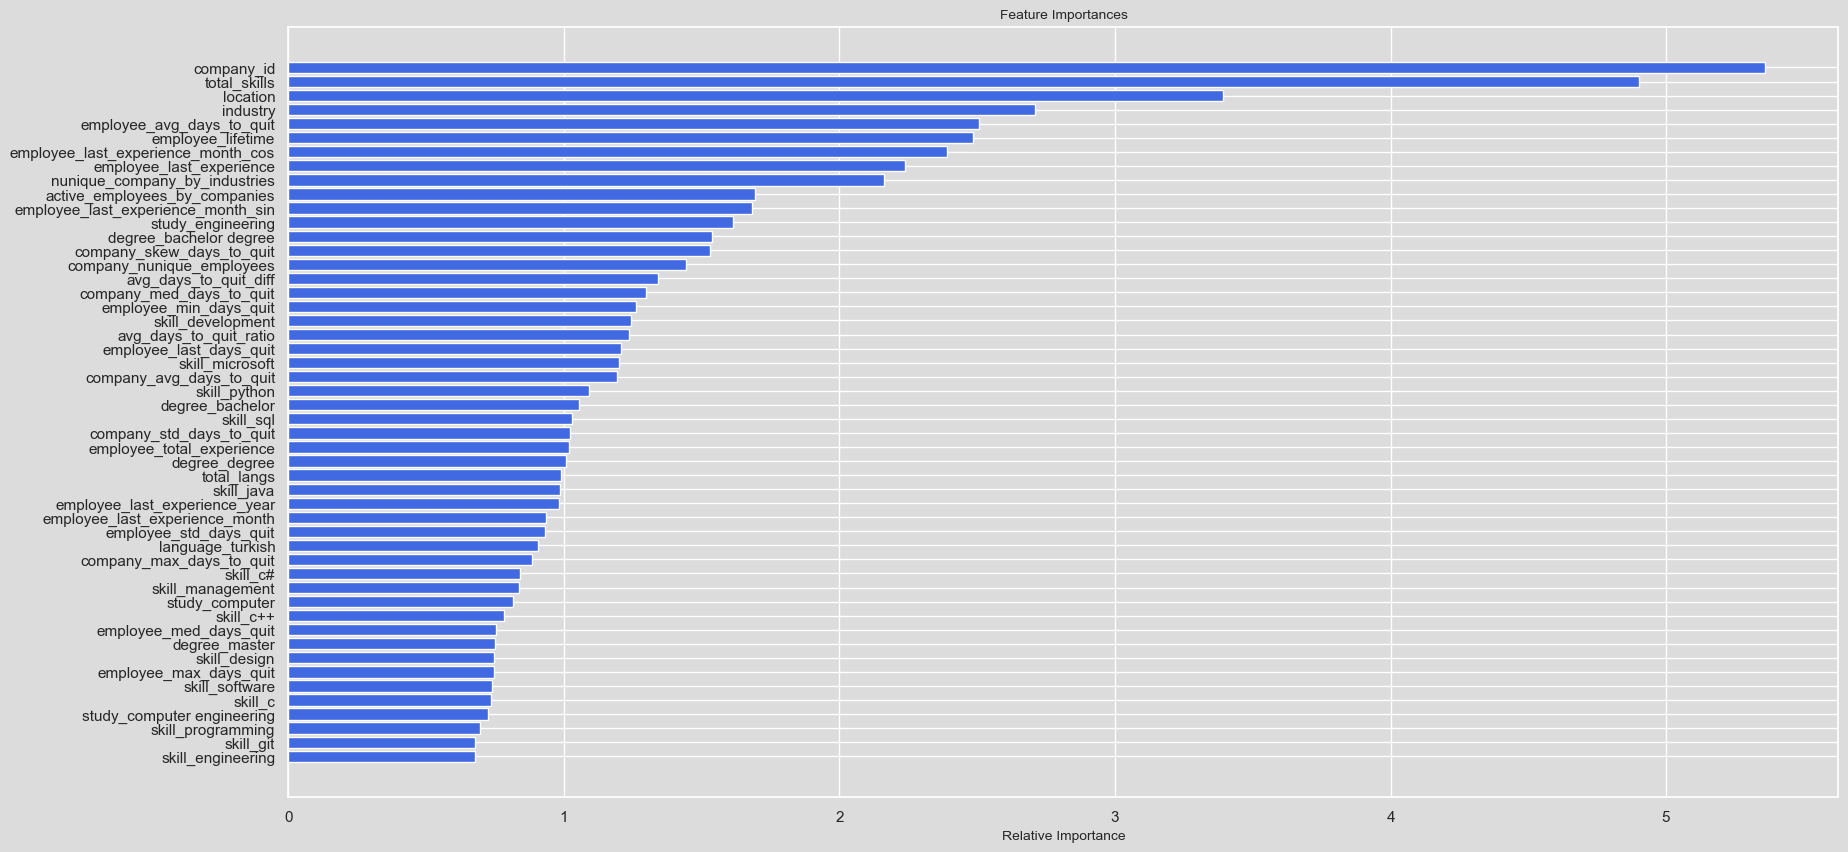

fold accuracy: 0.7873712798461017
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
0:	learn: 0.6382011	test: 0.6461469	best: 0.6461469 (0)	total: 219ms	remaining: 14m 37s
250:	learn: 0.8125707	test: 0.7545547	best: 0.7548942 (249)	total: 51.7s	remaining: 12m 52s
500:	learn: 0.8603277	test: 0.7682471	best: 0.7682471 (500)	total: 1m 43s	remaining: 12m 1s
750:	learn: 0.9080168	test: 0.7774131	best: 0.7774131 (750)	total: 2m 36s	remaining: 11m 16s
1000:	learn: 0.9348377	test: 0.7855607	best: 0.7855607 (993)	total: 3m 28s	remaining: 10m 25s
1250:	learn: 0.9543027	test: 0.7888424	best: 0.7889555 (1249)	total: 4m 21s	remaining: 9m 35s
1500:	learn: 0.9673623	test: 0.7922372	best: 0.7928030 (1385)	total: 5m 14s	remaining: 8m 43s
1750:	learn: 0.9753520	test: 0.7947267	best: 0.7955188 (1678)	total: 6m 6s	remaining: 7m 50s
2000:	learn: 0.9817120	test: 0.7947267	best: 0.7961978 (1960)	total: 6m 58s	remaining: 6m 57s
2250:	learn: 0

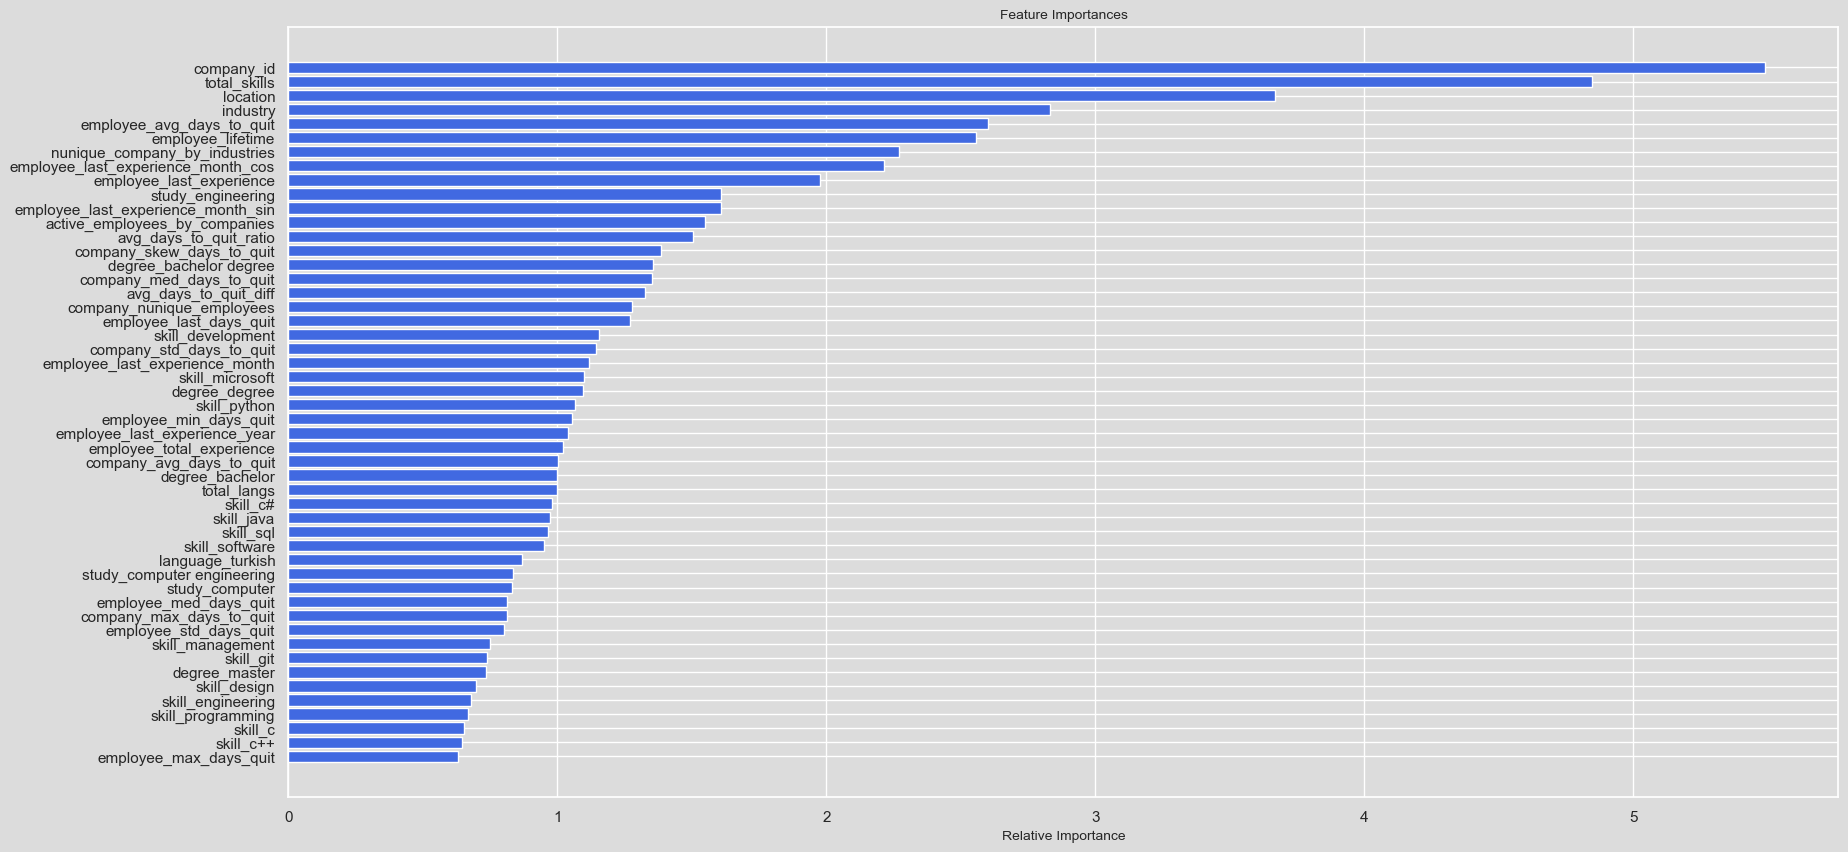

fold accuracy: 0.7963109652597036
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
0:	learn: 0.6408492	test: 0.6335861	best: 0.6335861 (0)	total: 258ms	remaining: 17m 11s
250:	learn: 0.8143588	test: 0.7374675	best: 0.7379201 (246)	total: 51.3s	remaining: 12m 46s
500:	learn: 0.8646734	test: 0.7525178	best: 0.7525178 (500)	total: 1m 42s	remaining: 11m 58s
750:	learn: 0.9075415	test: 0.7616838	best: 0.7624760 (736)	total: 2m 34s	remaining: 11m 10s
1000:	learn: 0.9370332	test: 0.7693787	best: 0.7701709 (922)	total: 3m 27s	remaining: 10m 20s
1250:	learn: 0.9573129	test: 0.7726604	best: 0.7734525 (1221)	total: 4m 19s	remaining: 9m 31s
1500:	learn: 0.9701915	test: 0.7753763	best: 0.7762815 (1474)	total: 5m 11s	remaining: 8m 39s
1750:	learn: 0.9775927	test: 0.7767342	best: 0.7769605 (1602)	total: 6m 4s	remaining: 7m 47s
2000:	learn: 0.9832285	test: 0.7796764	best: 0.7799027 (1998)	total: 6m 57s	remaining: 6m 57s
2250:	learn: 

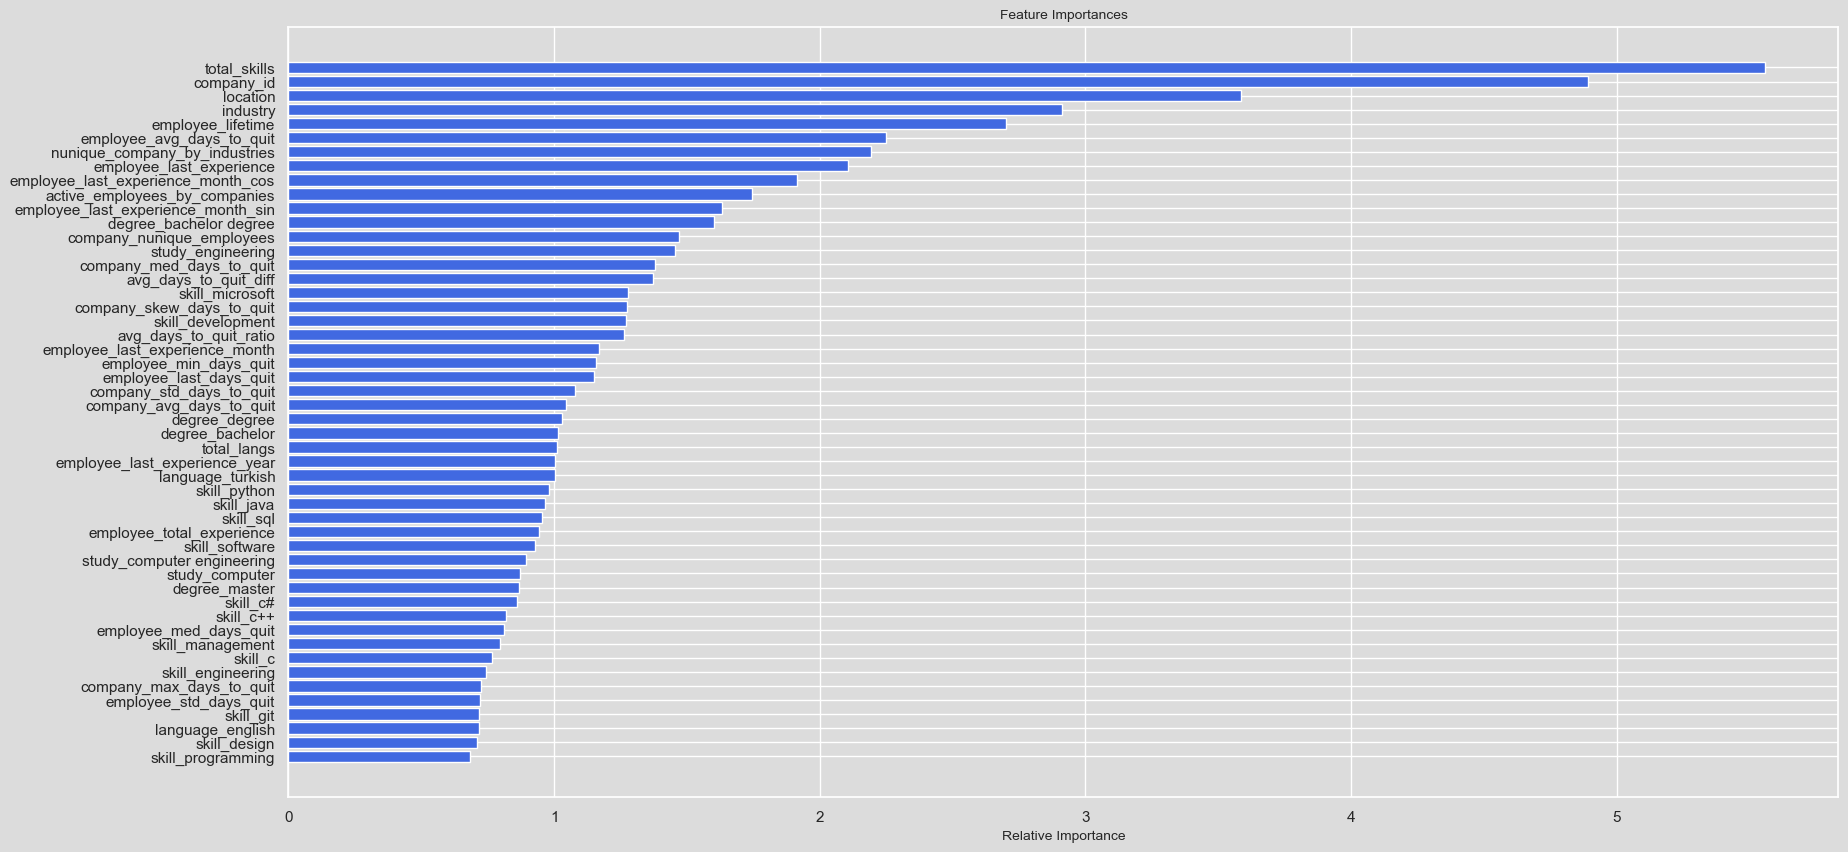

fold accuracy: 0.7823922145524499
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
0:	learn: 0.6601408	test: 0.6410140	best: 0.6410140 (0)	total: 324ms	remaining: 21m 36s
250:	learn: 0.8174411	test: 0.7427569	best: 0.7430964 (247)	total: 51.4s	remaining: 12m 47s
500:	learn: 0.8656497	test: 0.7566772	best: 0.7567904 (496)	total: 1m 43s	remaining: 12m
750:	learn: 0.9034697	test: 0.7681077	best: 0.7689000 (741)	total: 2m 35s	remaining: 11m 14s
1000:	learn: 0.9329380	test: 0.7772748	best: 0.7779538 (985)	total: 3m 29s	remaining: 10m 26s
1250:	learn: 0.9516556	test: 0.7822544	best: 0.7827071 (1177)	total: 4m 21s	remaining: 9m 34s
1500:	learn: 0.9650092	test: 0.7844047	best: 0.7855364 (1461)	total: 5m 16s	remaining: 8m 46s
1750:	learn: 0.9729760	test: 0.7865550	best: 0.7879131 (1542)	total: 6m 7s	remaining: 7m 52s
2000:	learn: 0.9796981	test: 0.7877999	best: 0.7883658 (1835)	total: 7m	remaining: 7m
2250:	learn: 0.9843379	te

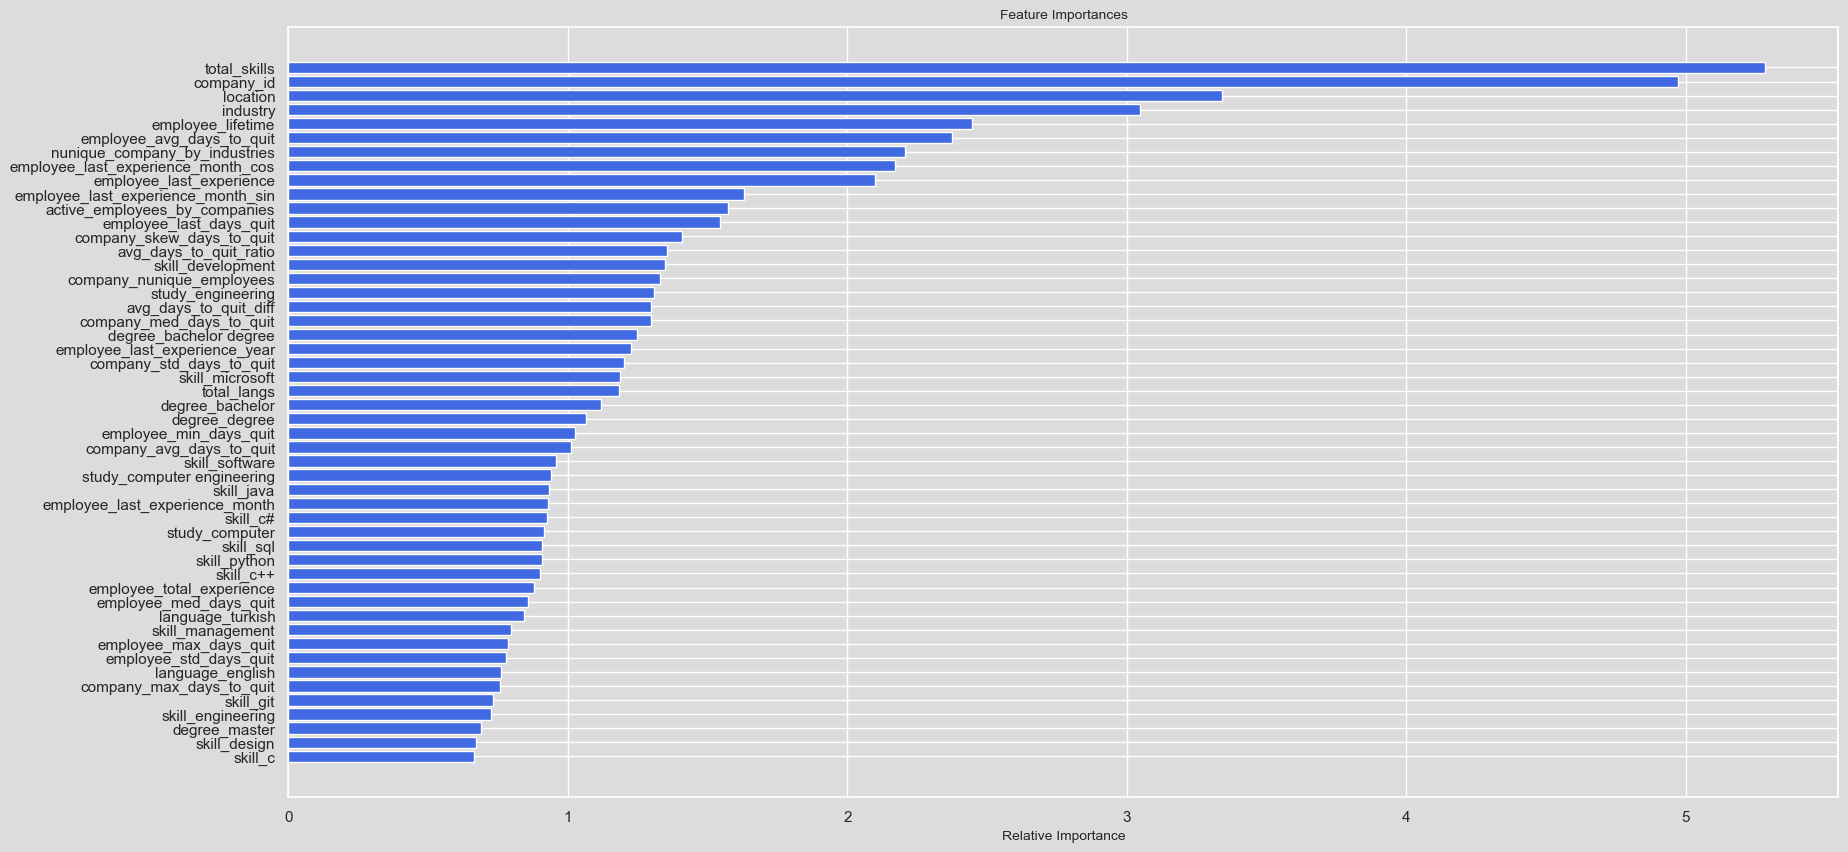

fold accuracy: 0.7901765504753282
-----------------------------------| Fold 5 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
0:	learn: 0.6559536	test: 0.6368266	best: 0.6368266 (0)	total: 346ms	remaining: 23m 5s
250:	learn: 0.8155173	test: 0.7469443	best: 0.7469443 (243)	total: 51.6s	remaining: 12m 50s
500:	learn: 0.8675735	test: 0.7623359	best: 0.7623359 (493)	total: 1m 43s	remaining: 11m 59s
750:	learn: 0.9094448	test: 0.7718425	best: 0.7719556 (749)	total: 2m 35s	remaining: 11m 11s
1000:	learn: 0.9362198	test: 0.7770484	best: 0.7770484 (1000)	total: 3m 27s	remaining: 10m 23s
1250:	learn: 0.9545074	test: 0.7787460	best: 0.7793119 (1185)	total: 4m 24s	remaining: 9m 40s
1500:	learn: 0.9662314	test: 0.7814622	best: 0.7816885 (1473)	total: 5m 18s	remaining: 8m 50s
1750:	learn: 0.9748546	test: 0.7813490	best: 0.7827071 (1689)	total: 6m 13s	remaining: 7m 59s
2000:	learn: 0.9811919	test: 0.7829335	best: 0.7834993 (1906)	total: 7m 7s	remaining: 7m 6s
2250:	learn: 0

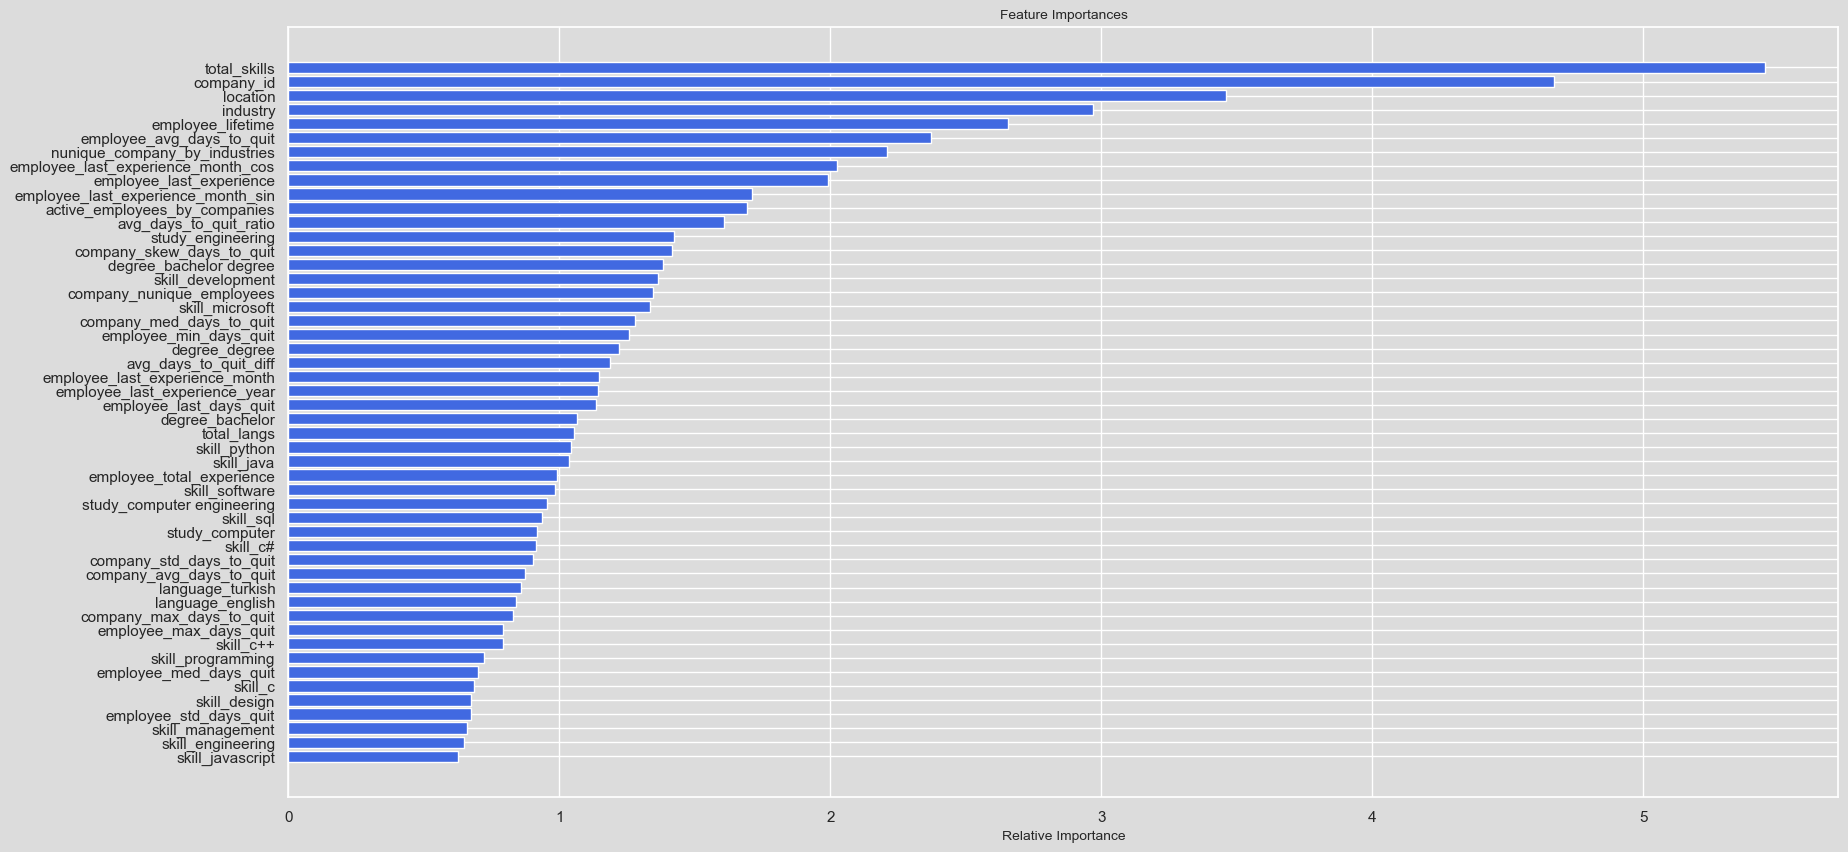

fold accuracy: 0.7870076957899502
-----------------------------------| Fold 6 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
0:	learn: 0.6594165	test: 0.6481440	best: 0.6481440 (0)	total: 341ms	remaining: 22m 43s
250:	learn: 0.8160378	test: 0.7429833	best: 0.7434359 (248)	total: 54.5s	remaining: 13m 34s
500:	learn: 0.8653102	test: 0.7564509	best: 0.7564509 (493)	total: 1m 46s	remaining: 12m 27s
750:	learn: 0.9090374	test: 0.7673155	best: 0.7674287 (741)	total: 2m 40s	remaining: 11m 32s
1000:	learn: 0.9378947	test: 0.7750113	best: 0.7756904 (954)	total: 3m 33s	remaining: 10m 38s
1250:	learn: 0.9570197	test: 0.7787460	best: 0.7793119 (1214)	total: 4m 25s	remaining: 9m 44s
1500:	learn: 0.9686531	test: 0.7818017	best: 0.7818017 (1488)	total: 5m 18s	remaining: 8m 50s
1750:	learn: 0.9770274	test: 0.7832730	best: 0.7839520 (1637)	total: 6m 11s	remaining: 7m 57s
2000:	learn: 0.9825725	test: 0.7838388	best: 0.7853101 (1939)	total: 7m 4s	remaining: 7m 4s
2250:	learn: 0

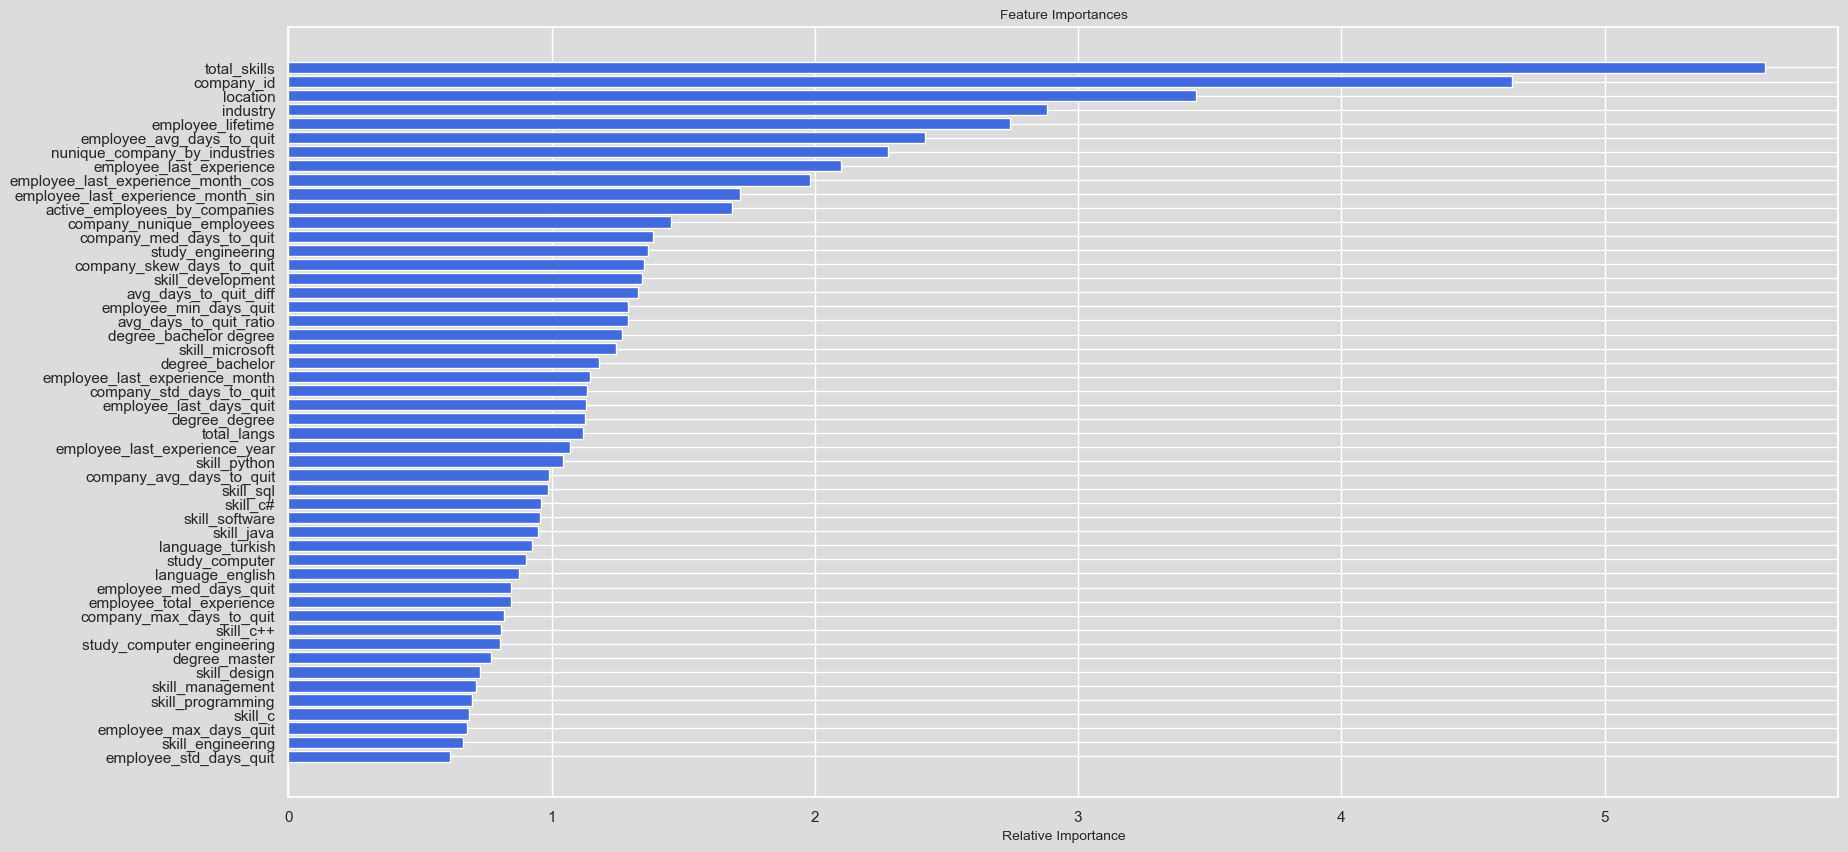

fold accuracy: 0.7889316432775011
accuracy: 0.7886983911427978
folds avg accuracy: 0.7886983915335057


In [6]:
cat1_scores, cat1_train_scores = get_model_scores(cat1, kf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #0.7886983911427978

-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69085
[250]	validation_0-logloss:0.54342
[500]	validation_0-logloss:0.51418
[750]	validation_0-logloss:0.49418
[1000]	validation_0-logloss:0.47929
[1250]	validation_0-logloss:0.46754
[1500]	validation_0-logloss:0.45952
[1750]	validation_0-logloss:0.45409
[2000]	validation_0-logloss:0.45046
[2250]	validation_0-logloss:0.44866
[2500]	validation_0-logloss:0.44791
[2750]	validation_0-logloss:0.44781
[3000]	validation_0-logloss:0.44829
[3199]	validation_0-logloss:0.44899


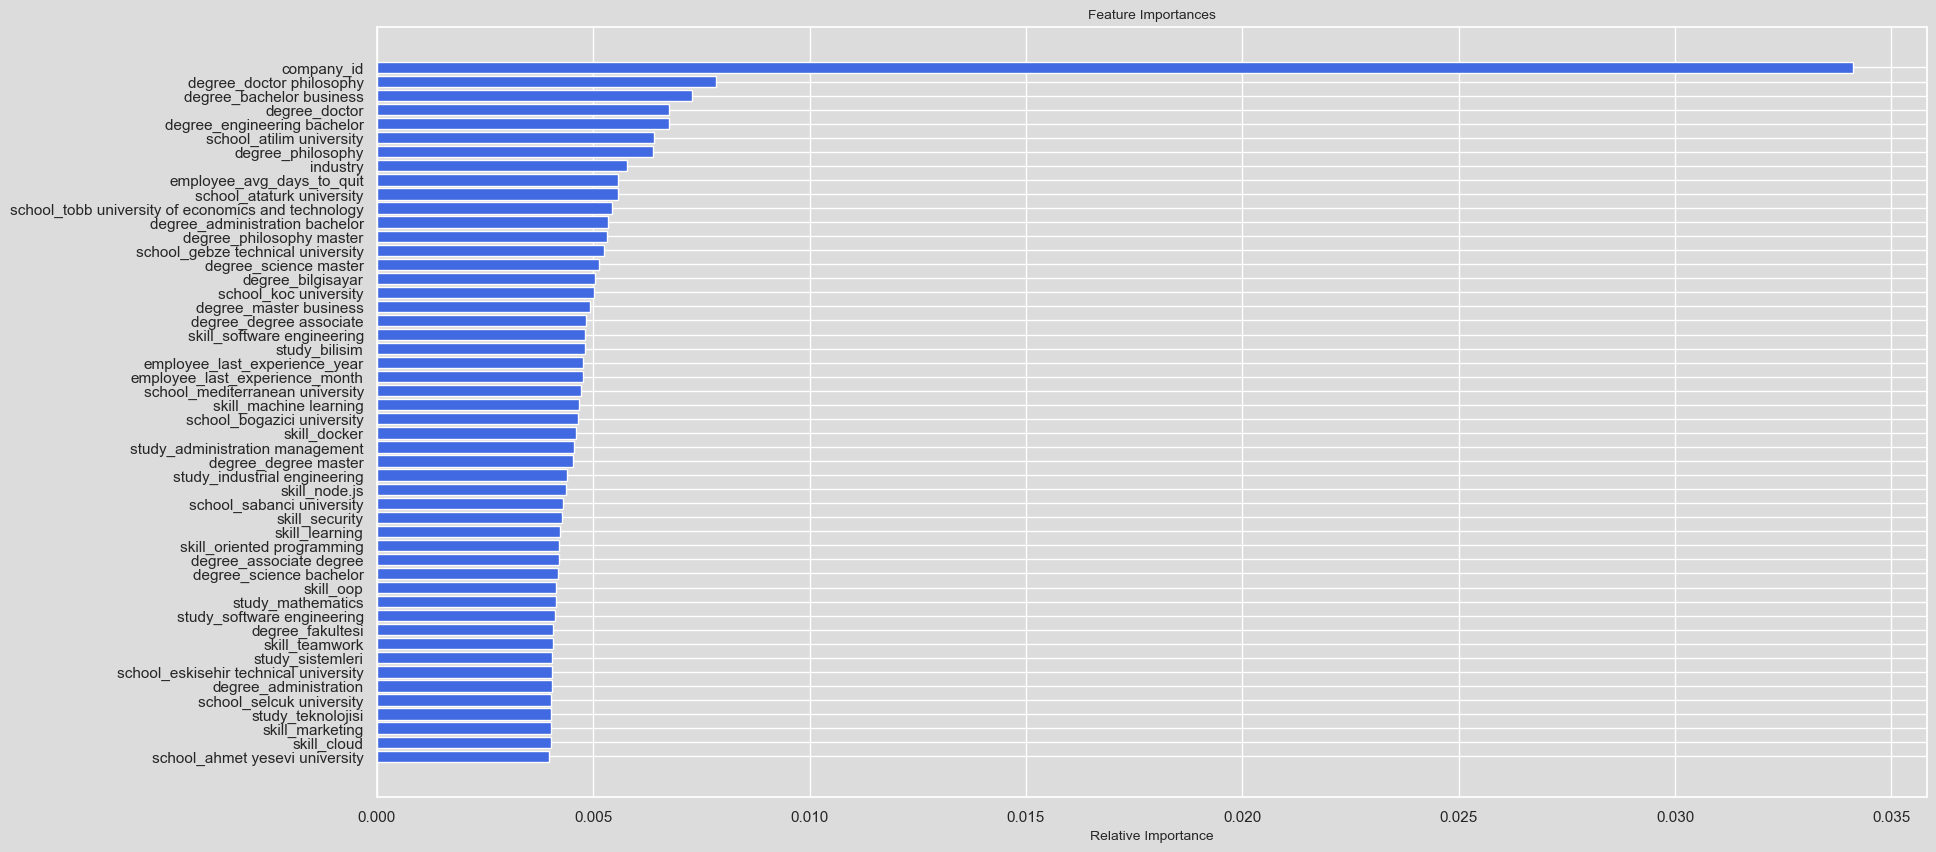

fold accuracy: 0.7802421636301913
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69059
[250]	validation_0-logloss:0.52821
[500]	validation_0-logloss:0.49531
[750]	validation_0-logloss:0.47342
[1000]	validation_0-logloss:0.45672
[1250]	validation_0-logloss:0.44462
[1500]	validation_0-logloss:0.43525
[1750]	validation_0-logloss:0.42947
[2000]	validation_0-logloss:0.42596
[2250]	validation_0-logloss:0.42394
[2500]	validation_0-logloss:0.42277
[2750]	validation_0-logloss:0.42288
[3000]	validation_0-logloss:0.42321
[3229]	validation_0-logloss:0.42448


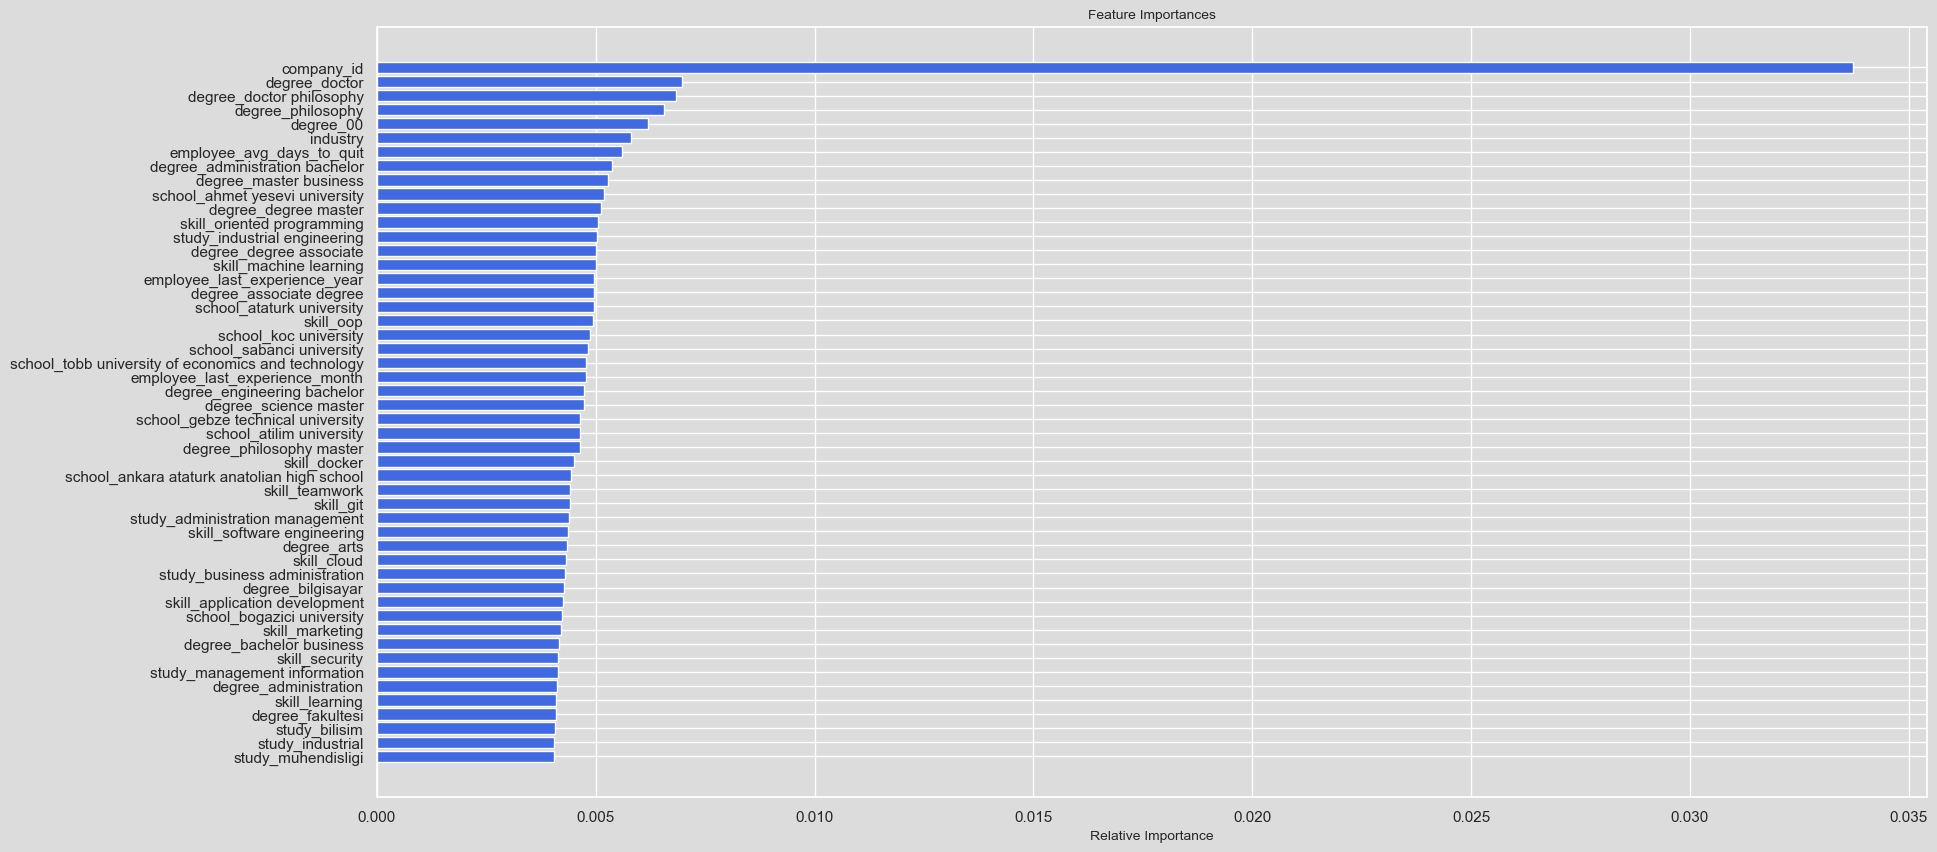

fold accuracy: 0.7949530383614348
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69067
[250]	validation_0-logloss:0.53988
[500]	validation_0-logloss:0.51034
[750]	validation_0-logloss:0.49057
[1000]	validation_0-logloss:0.47623
[1250]	validation_0-logloss:0.46469
[1500]	validation_0-logloss:0.45701
[1750]	validation_0-logloss:0.45246
[2000]	validation_0-logloss:0.44997
[2250]	validation_0-logloss:0.44882
[2500]	validation_0-logloss:0.44892
[2750]	validation_0-logloss:0.44982
[2848]	validation_0-logloss:0.45041


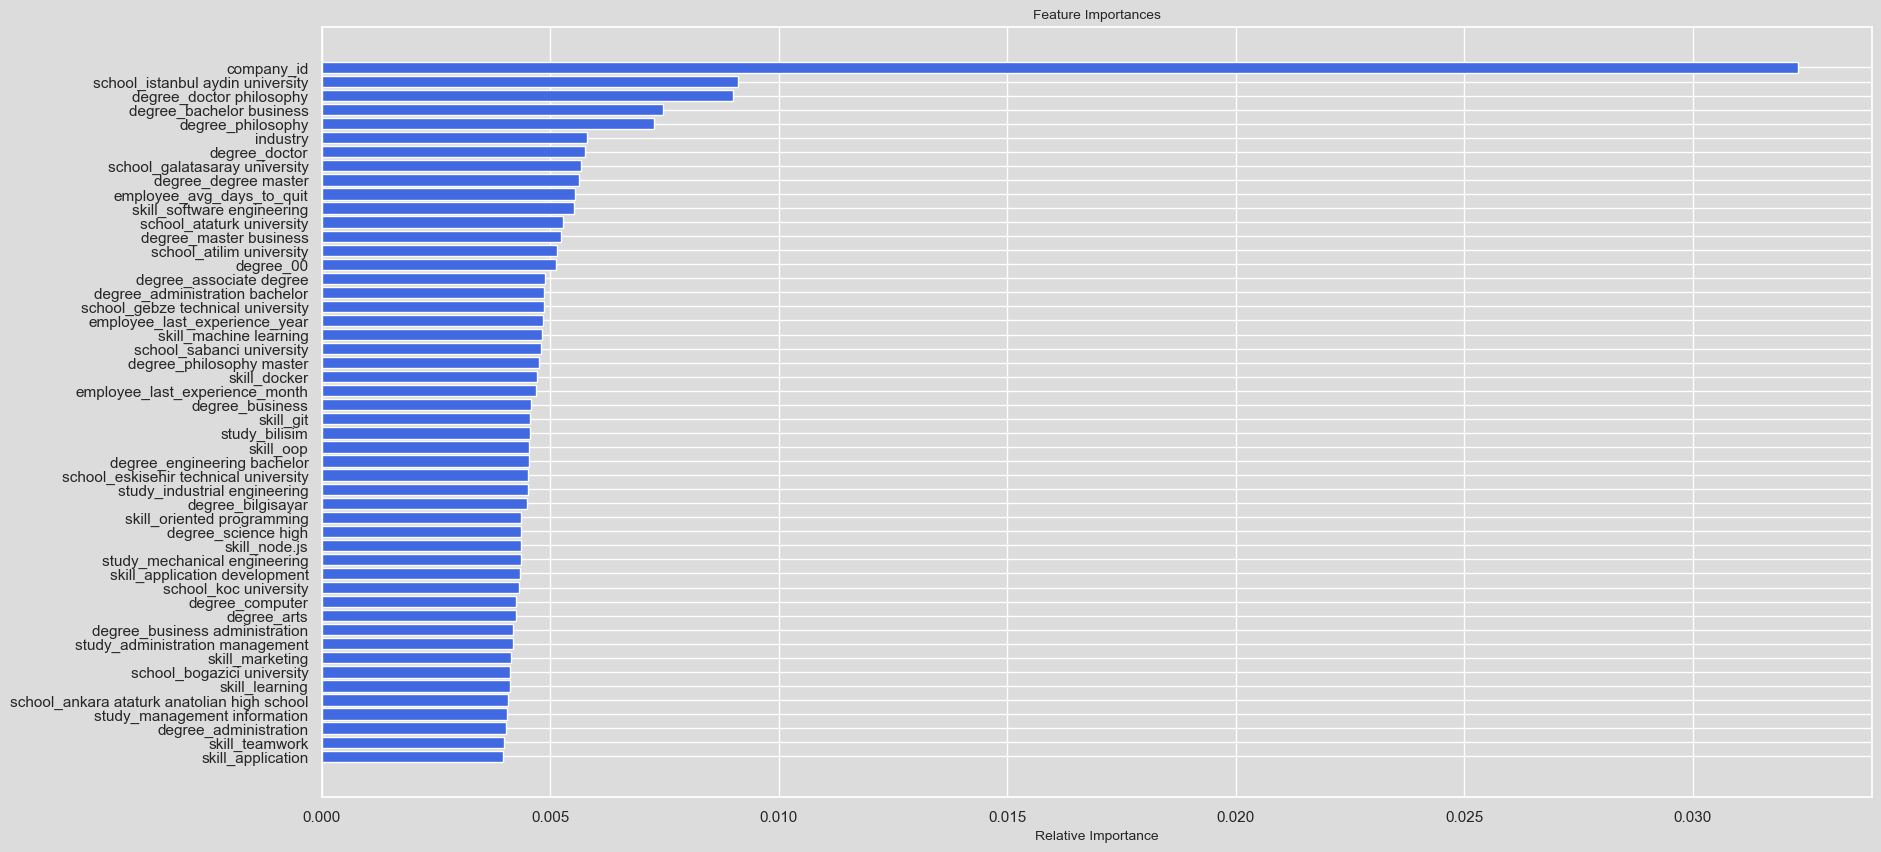

fold accuracy: 0.7825053751273057
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69071
[250]	validation_0-logloss:0.54286
[500]	validation_0-logloss:0.51487
[750]	validation_0-logloss:0.49451
[1000]	validation_0-logloss:0.47915
[1250]	validation_0-logloss:0.46674
[1500]	validation_0-logloss:0.45807
[1750]	validation_0-logloss:0.45251
[2000]	validation_0-logloss:0.44937
[2250]	validation_0-logloss:0.44699
[2500]	validation_0-logloss:0.44610
[2750]	validation_0-logloss:0.44626
[3000]	validation_0-logloss:0.44709
[3087]	validation_0-logloss:0.44743


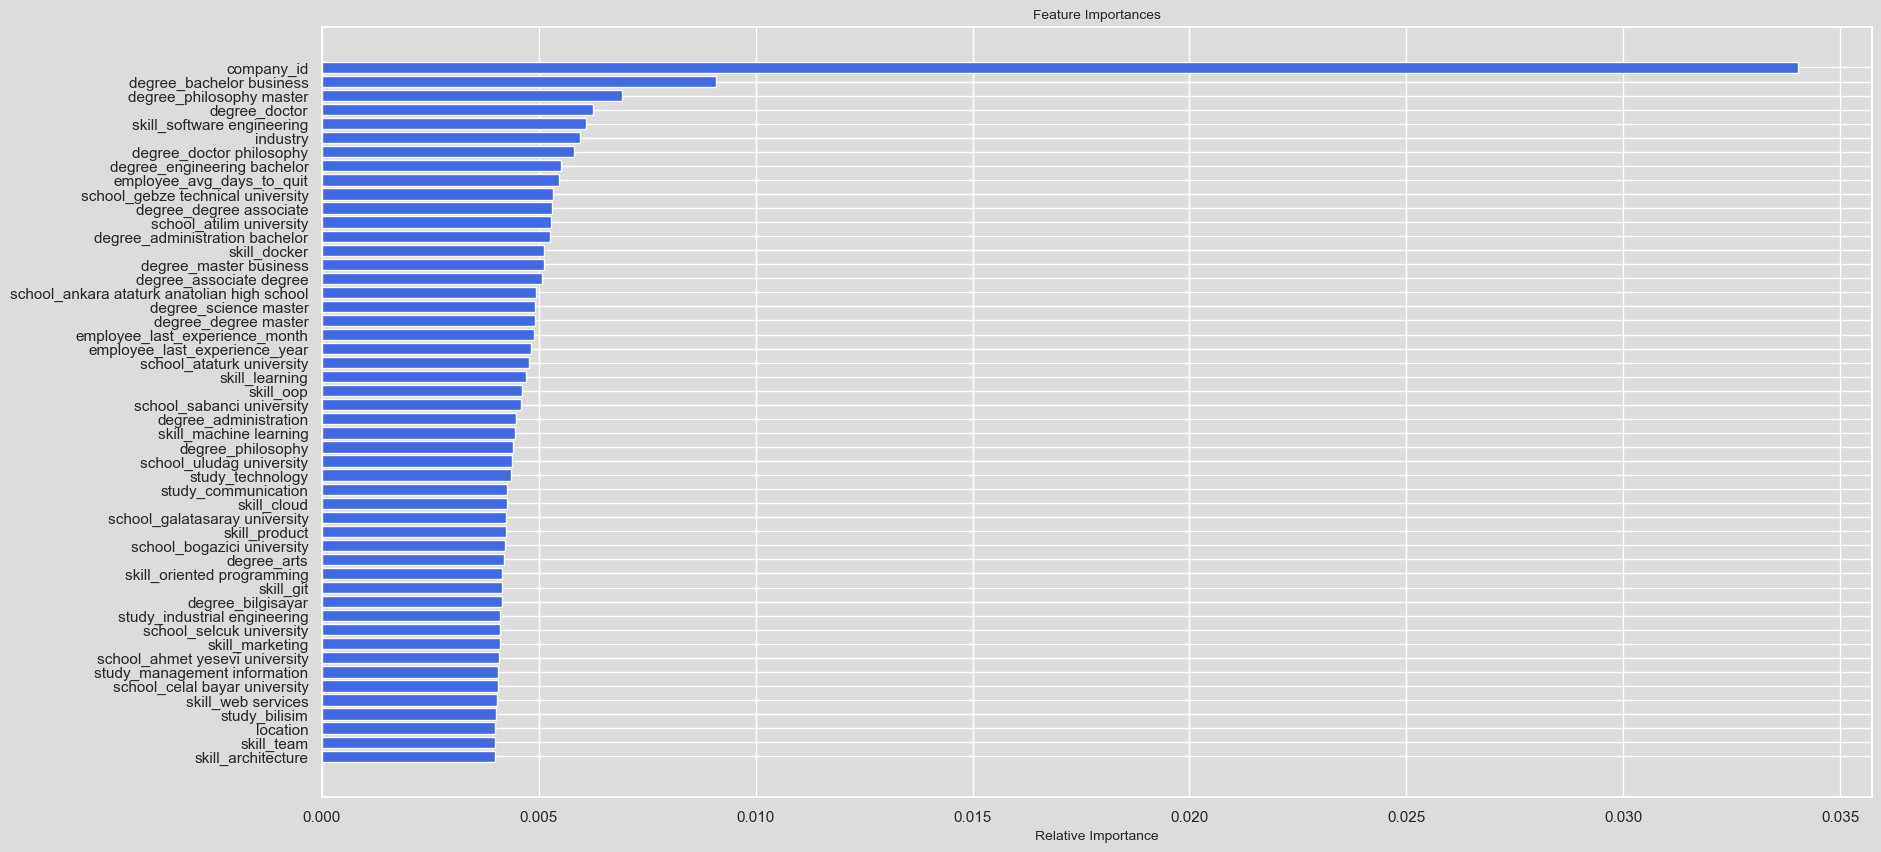

fold accuracy: 0.7856496152105025
-----------------------------------| Fold 5 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69068
[250]	validation_0-logloss:0.53927
[500]	validation_0-logloss:0.51055
[750]	validation_0-logloss:0.49157
[1000]	validation_0-logloss:0.47653
[1250]	validation_0-logloss:0.46553
[1500]	validation_0-logloss:0.45783
[1750]	validation_0-logloss:0.45355
[2000]	validation_0-logloss:0.45121
[2250]	validation_0-logloss:0.45058
[2500]	validation_0-logloss:0.45071
[2726]	validation_0-logloss:0.45136


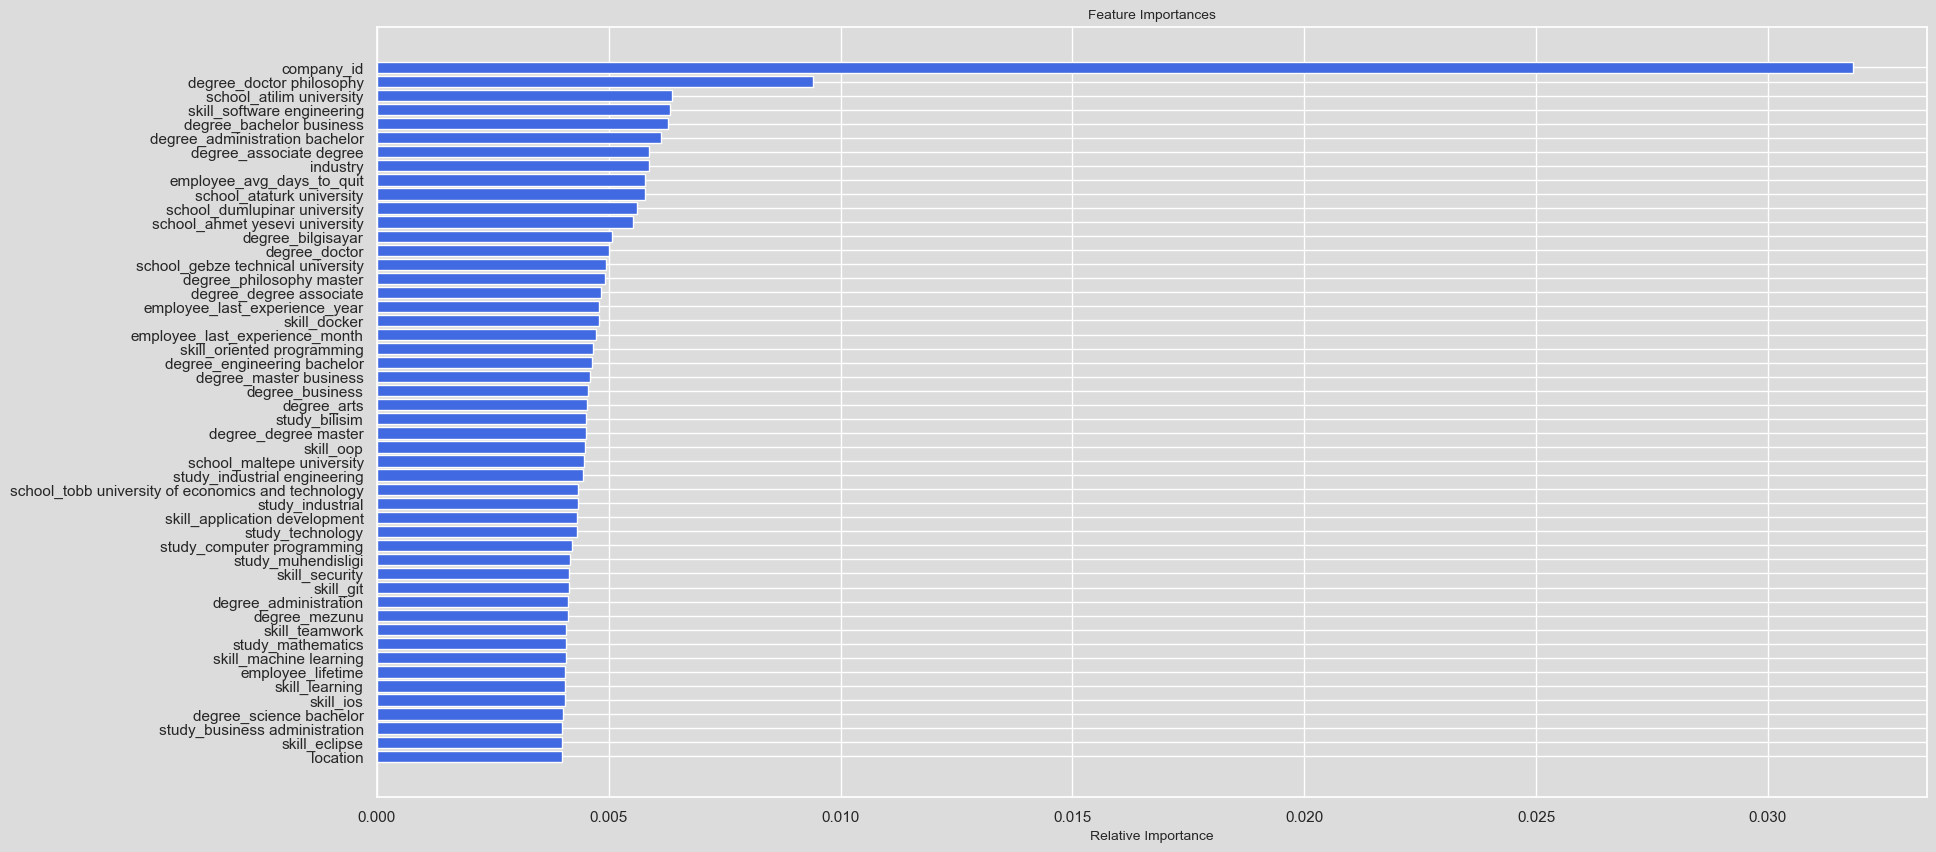

fold accuracy: 0.7825939339067451
-----------------------------------| Fold 6 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69073
[250]	validation_0-logloss:0.53504
[500]	validation_0-logloss:0.50470
[750]	validation_0-logloss:0.48433
[1000]	validation_0-logloss:0.46904
[1250]	validation_0-logloss:0.45744
[1500]	validation_0-logloss:0.44945
[1750]	validation_0-logloss:0.44414
[2000]	validation_0-logloss:0.44077
[2250]	validation_0-logloss:0.43882
[2500]	validation_0-logloss:0.43845
[2750]	validation_0-logloss:0.43900
[3000]	validation_0-logloss:0.43983
[3059]	validation_0-logloss:0.44012


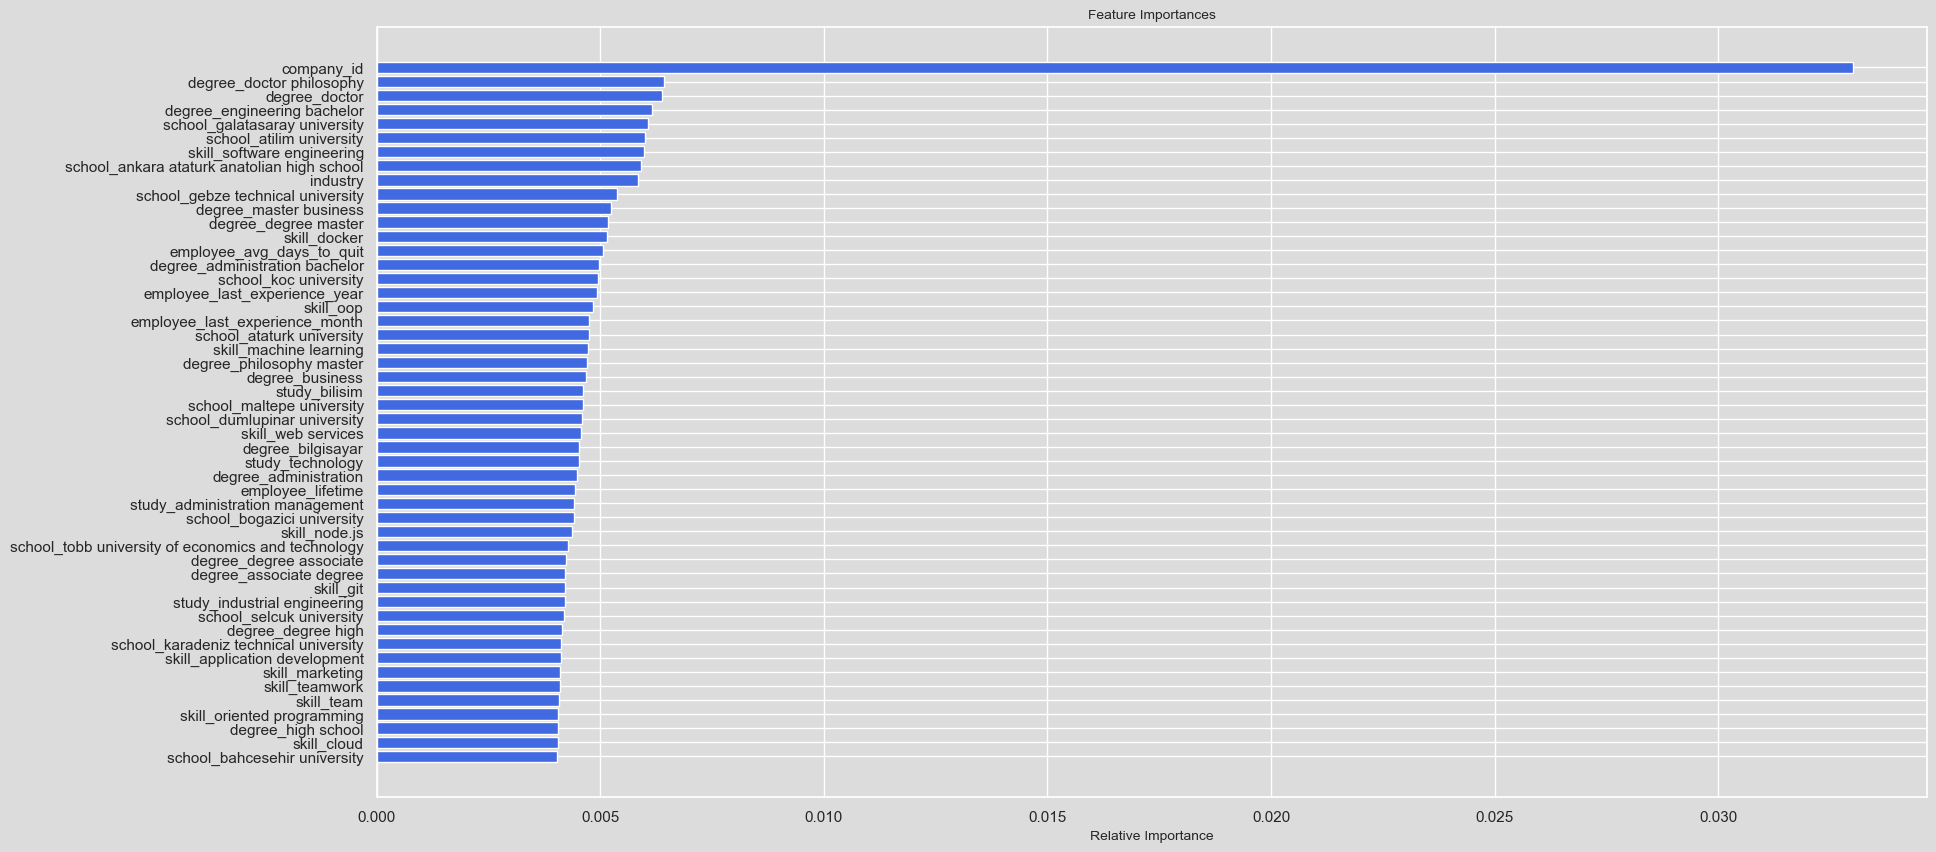

fold accuracy: 0.789271163422363
accuracy: 0.7858692166959015
folds avg accuracy: 0.7858692149430904


In [7]:
xgb1_scores, xgb1_train_scores = get_model_scores(xgb1, kf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #0.7870197476376394

-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69072
[250]	validation_0-logloss:0.54441
[500]	validation_0-logloss:0.52205
[750]	validation_0-logloss:0.50555
[1000]	validation_0-logloss:0.49343
[1250]	validation_0-logloss:0.48463
[1500]	validation_0-logloss:0.47694
[1750]	validation_0-logloss:0.47063
[2000]	validation_0-logloss:0.46501
[2250]	validation_0-logloss:0.46083
[2500]	validation_0-logloss:0.45777
[2750]	validation_0-logloss:0.45539
[3000]	validation_0-logloss:0.45383
[3250]	validation_0-logloss:0.45301
[3500]	validation_0-logloss:0.45259
[3750]	validation_0-logloss:0.45256
[4000]	validation_0-logloss:0.45300
[4250]	validation_0-logloss:0.45364
[4280]	validation_0-logloss:0.45369


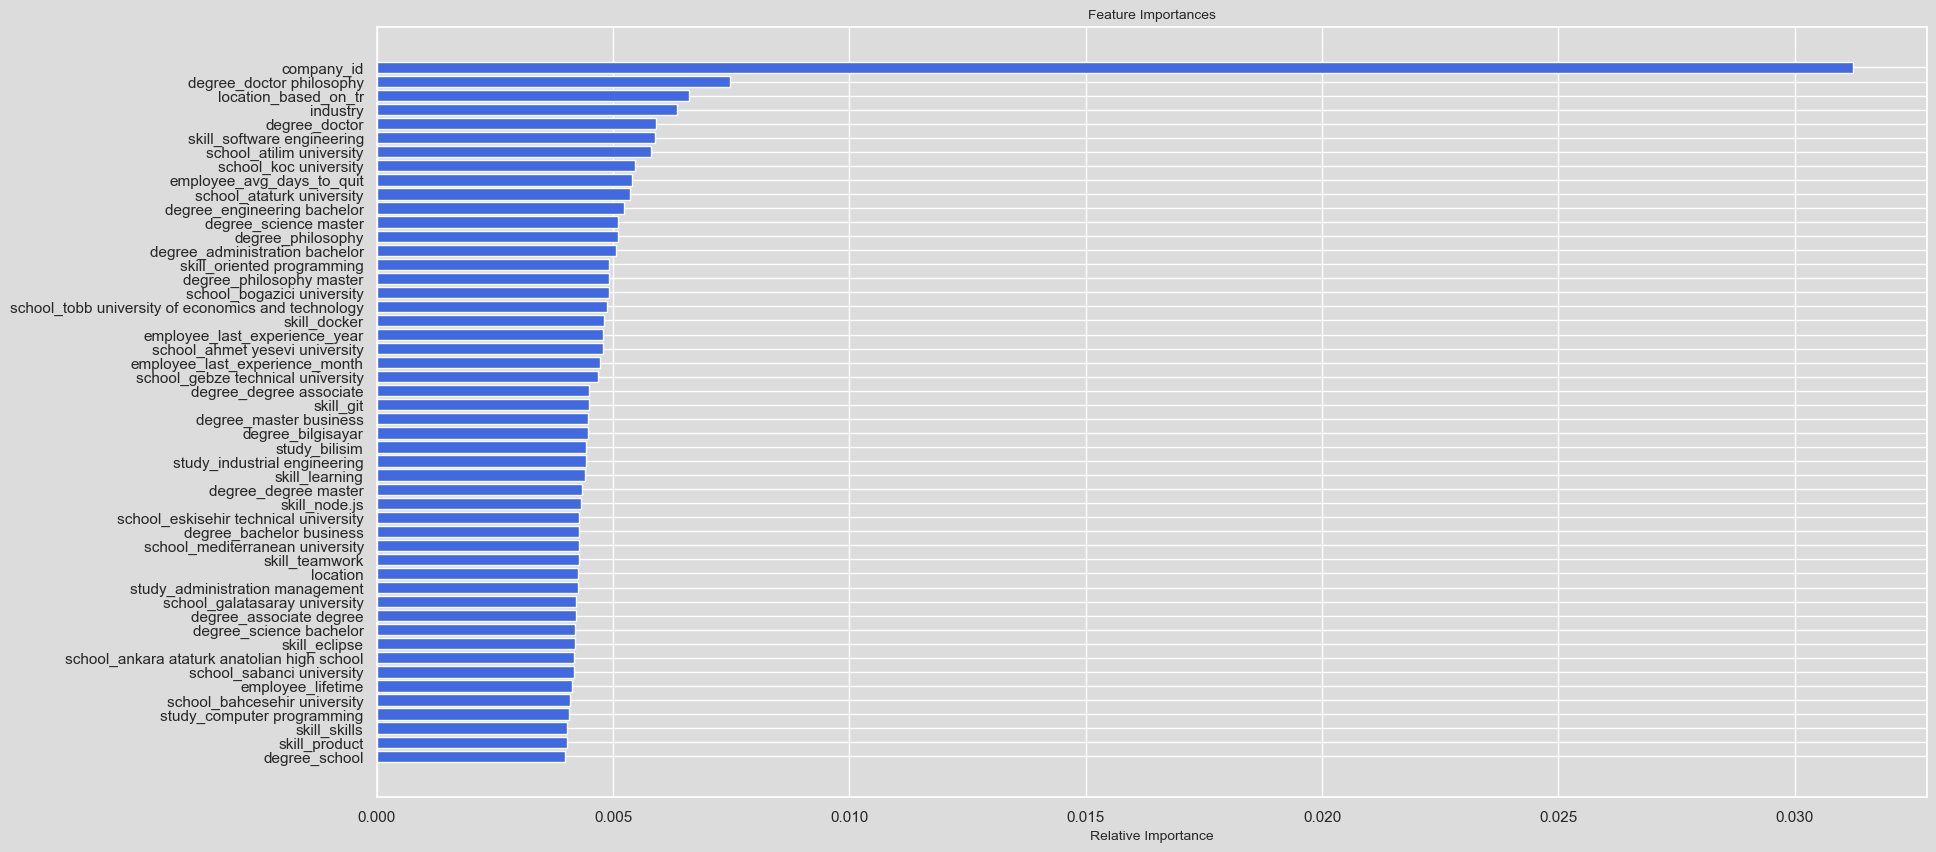

fold accuracy: 0.781147448229037
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69056
[250]	validation_0-logloss:0.52963
[500]	validation_0-logloss:0.50379
[750]	validation_0-logloss:0.48743
[1000]	validation_0-logloss:0.47424
[1250]	validation_0-logloss:0.46357
[1500]	validation_0-logloss:0.45545
[1750]	validation_0-logloss:0.44838
[2000]	validation_0-logloss:0.44255
[2250]	validation_0-logloss:0.43827
[2500]	validation_0-logloss:0.43500
[2750]	validation_0-logloss:0.43261
[3000]	validation_0-logloss:0.43106
[3250]	validation_0-logloss:0.43034
[3500]	validation_0-logloss:0.42960
[3750]	validation_0-logloss:0.42935
[4000]	validation_0-logloss:0.42948
[4211]	validation_0-logloss:0.42981


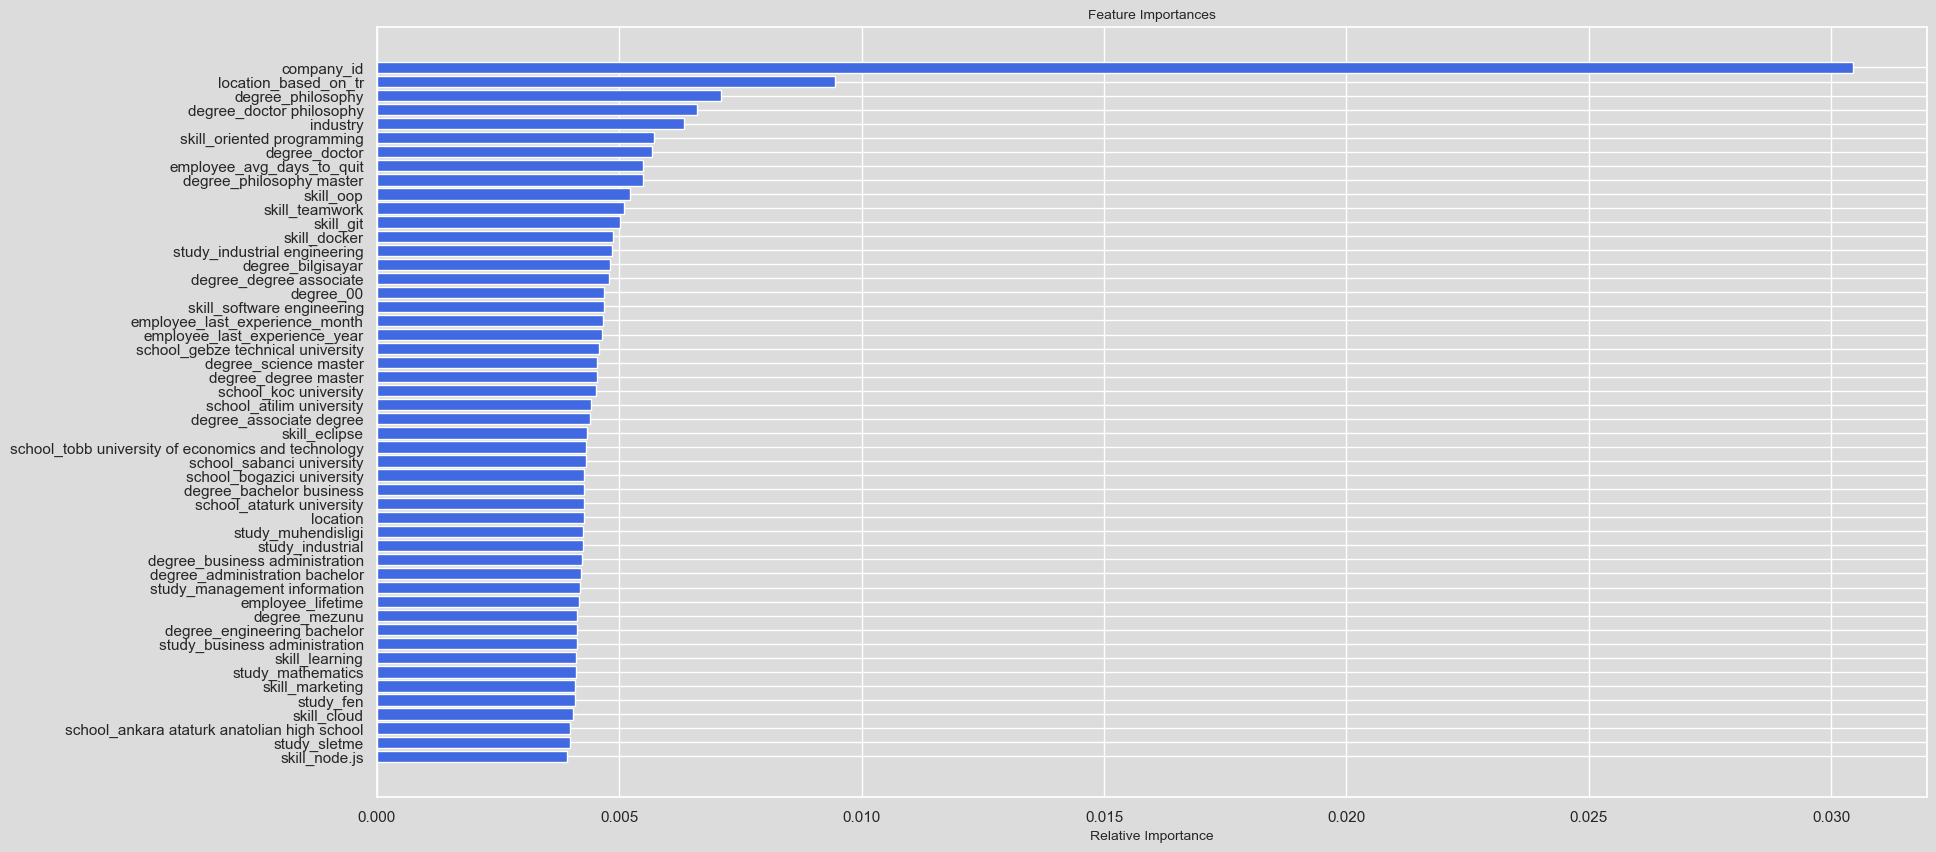

fold accuracy: 0.794500396062012
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 288)
val: (8837, 288)
[0]	validation_0-logloss:0.69063
[250]	validation_0-logloss:0.54070
[500]	validation_0-logloss:0.51716
[750]	validation_0-logloss:0.50156
[1000]	validation_0-logloss:0.48998
[1250]	validation_0-logloss:0.48042
[1500]	validation_0-logloss:0.47299
[1750]	validation_0-logloss:0.46656
[2000]	validation_0-logloss:0.46177
[2250]	validation_0-logloss:0.45805
[2500]	validation_0-logloss:0.45558
[2750]	validation_0-logloss:0.45427
[3000]	validation_0-logloss:0.45345
[3250]	validation_0-logloss:0.45278
[3500]	validation_0-logloss:0.45321
[3750]	validation_0-logloss:0.45353
[3755]	validation_0-logloss:0.45351


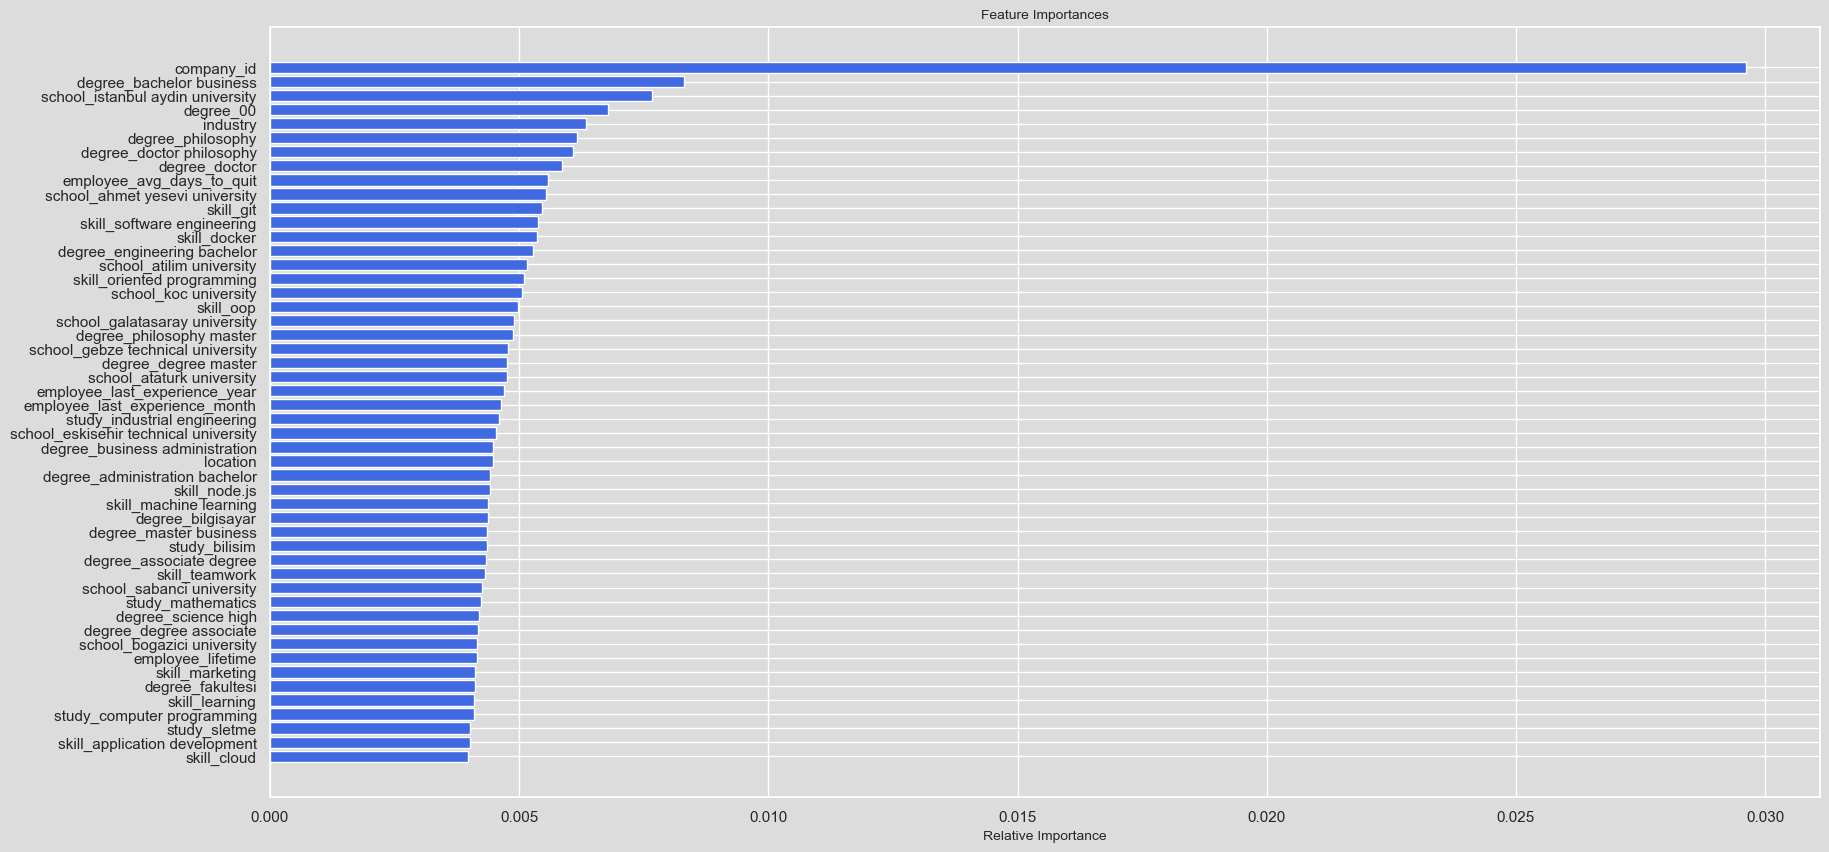

fold accuracy: 0.7827316962770171
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69069
[250]	validation_0-logloss:0.54358
[500]	validation_0-logloss:0.52144
[750]	validation_0-logloss:0.50612
[1000]	validation_0-logloss:0.49386
[1250]	validation_0-logloss:0.48357
[1500]	validation_0-logloss:0.47529
[1750]	validation_0-logloss:0.46820
[2000]	validation_0-logloss:0.46296
[2250]	validation_0-logloss:0.45828
[2500]	validation_0-logloss:0.45497
[2750]	validation_0-logloss:0.45248
[3000]	validation_0-logloss:0.45102
[3250]	validation_0-logloss:0.45010
[3500]	validation_0-logloss:0.44948
[3750]	validation_0-logloss:0.44879
[4000]	validation_0-logloss:0.44881
[4250]	validation_0-logloss:0.44920
[4321]	validation_0-logloss:0.44932


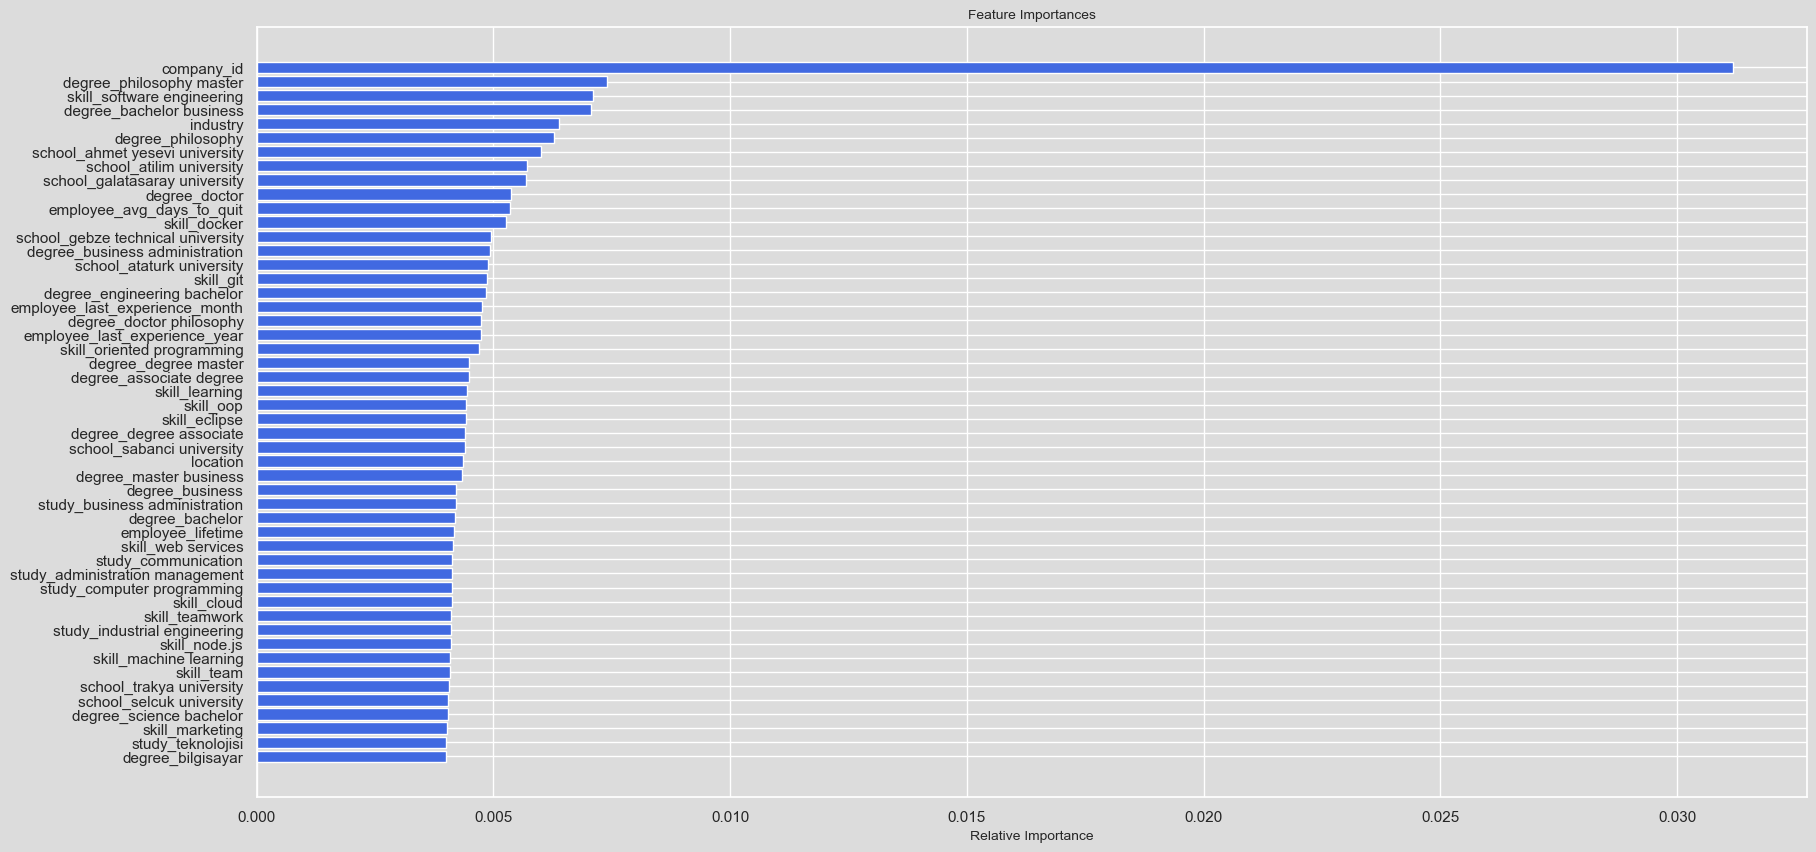

fold accuracy: 0.7847442281575373
-----------------------------------| Fold 5 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69077
[250]	validation_0-logloss:0.54053
[500]	validation_0-logloss:0.51645
[750]	validation_0-logloss:0.50119
[1000]	validation_0-logloss:0.48945
[1250]	validation_0-logloss:0.48026
[1500]	validation_0-logloss:0.47264
[1750]	validation_0-logloss:0.46658
[2000]	validation_0-logloss:0.46185
[2250]	validation_0-logloss:0.45813
[2500]	validation_0-logloss:0.45557
[2750]	validation_0-logloss:0.45398
[3000]	validation_0-logloss:0.45328
[3250]	validation_0-logloss:0.45284
[3500]	validation_0-logloss:0.45317
[3686]	validation_0-logloss:0.45342


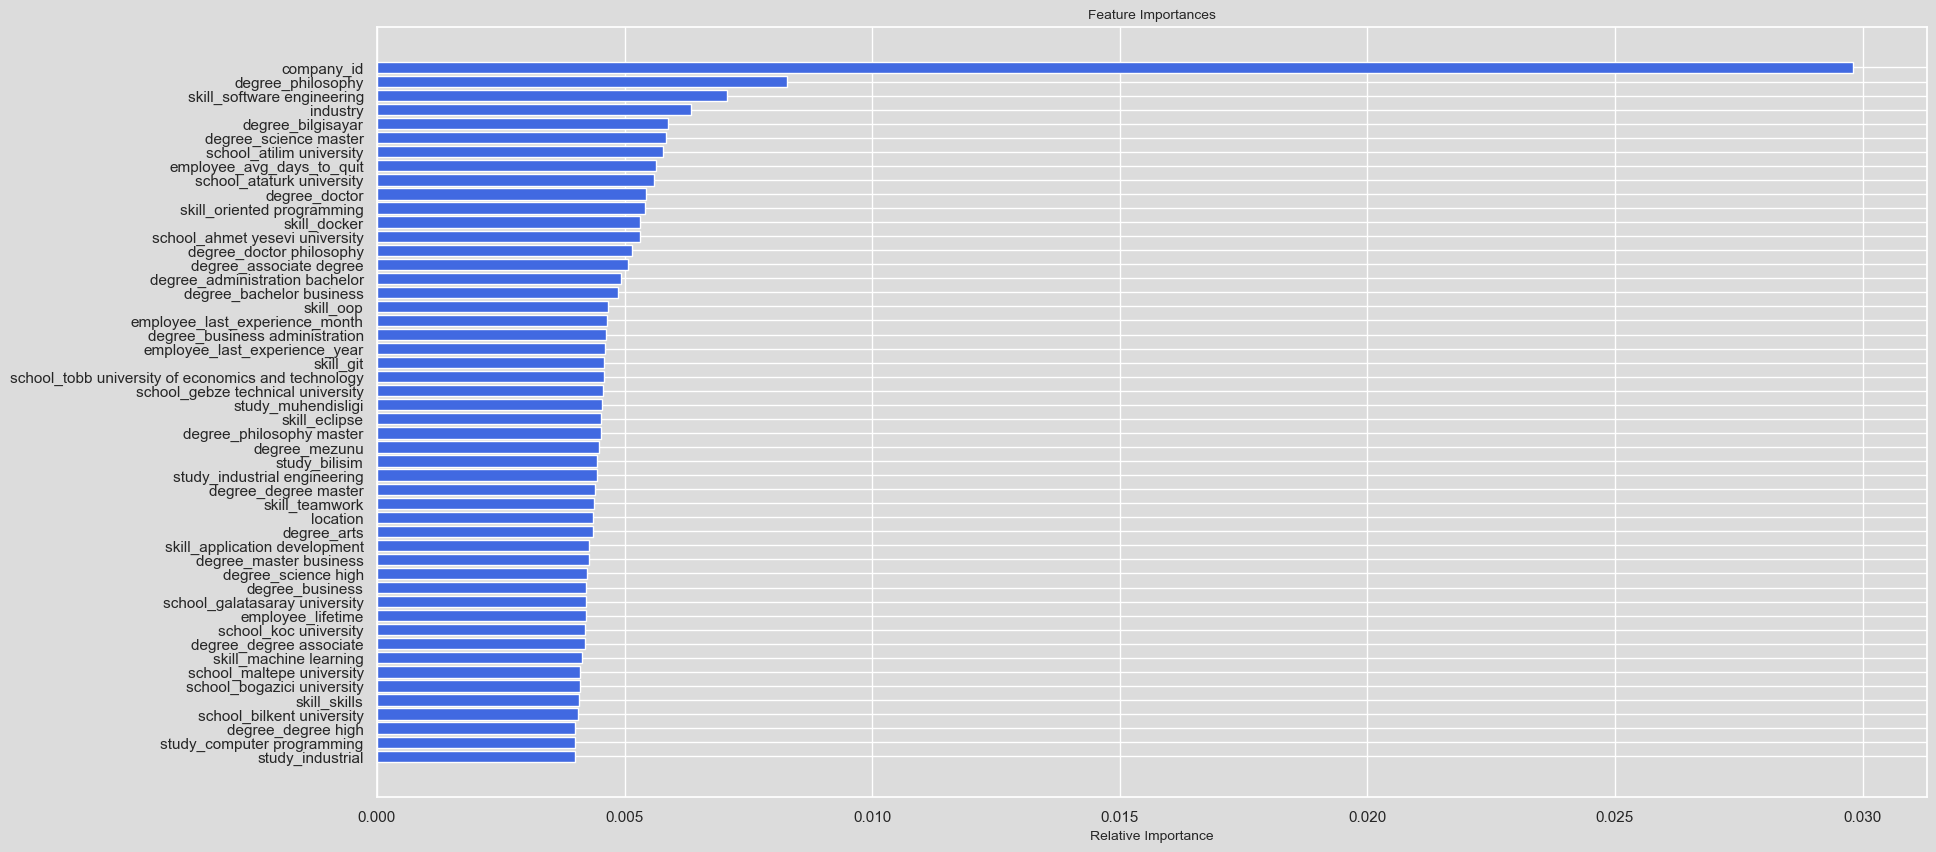

fold accuracy: 0.7856496152105025
-----------------------------------| Fold 6 |-----------------------------------
train: (44183, 288)
val: (8836, 288)
[0]	validation_0-logloss:0.69068
[250]	validation_0-logloss:0.53662
[500]	validation_0-logloss:0.51202
[750]	validation_0-logloss:0.49603
[1000]	validation_0-logloss:0.48395
[1250]	validation_0-logloss:0.47372
[1500]	validation_0-logloss:0.46581
[1750]	validation_0-logloss:0.45927
[2000]	validation_0-logloss:0.45406
[2250]	validation_0-logloss:0.44987
[2500]	validation_0-logloss:0.44716
[2750]	validation_0-logloss:0.44476
[3000]	validation_0-logloss:0.44328
[3250]	validation_0-logloss:0.44272
[3500]	validation_0-logloss:0.44236
[3750]	validation_0-logloss:0.44271
[3996]	validation_0-logloss:0.44310


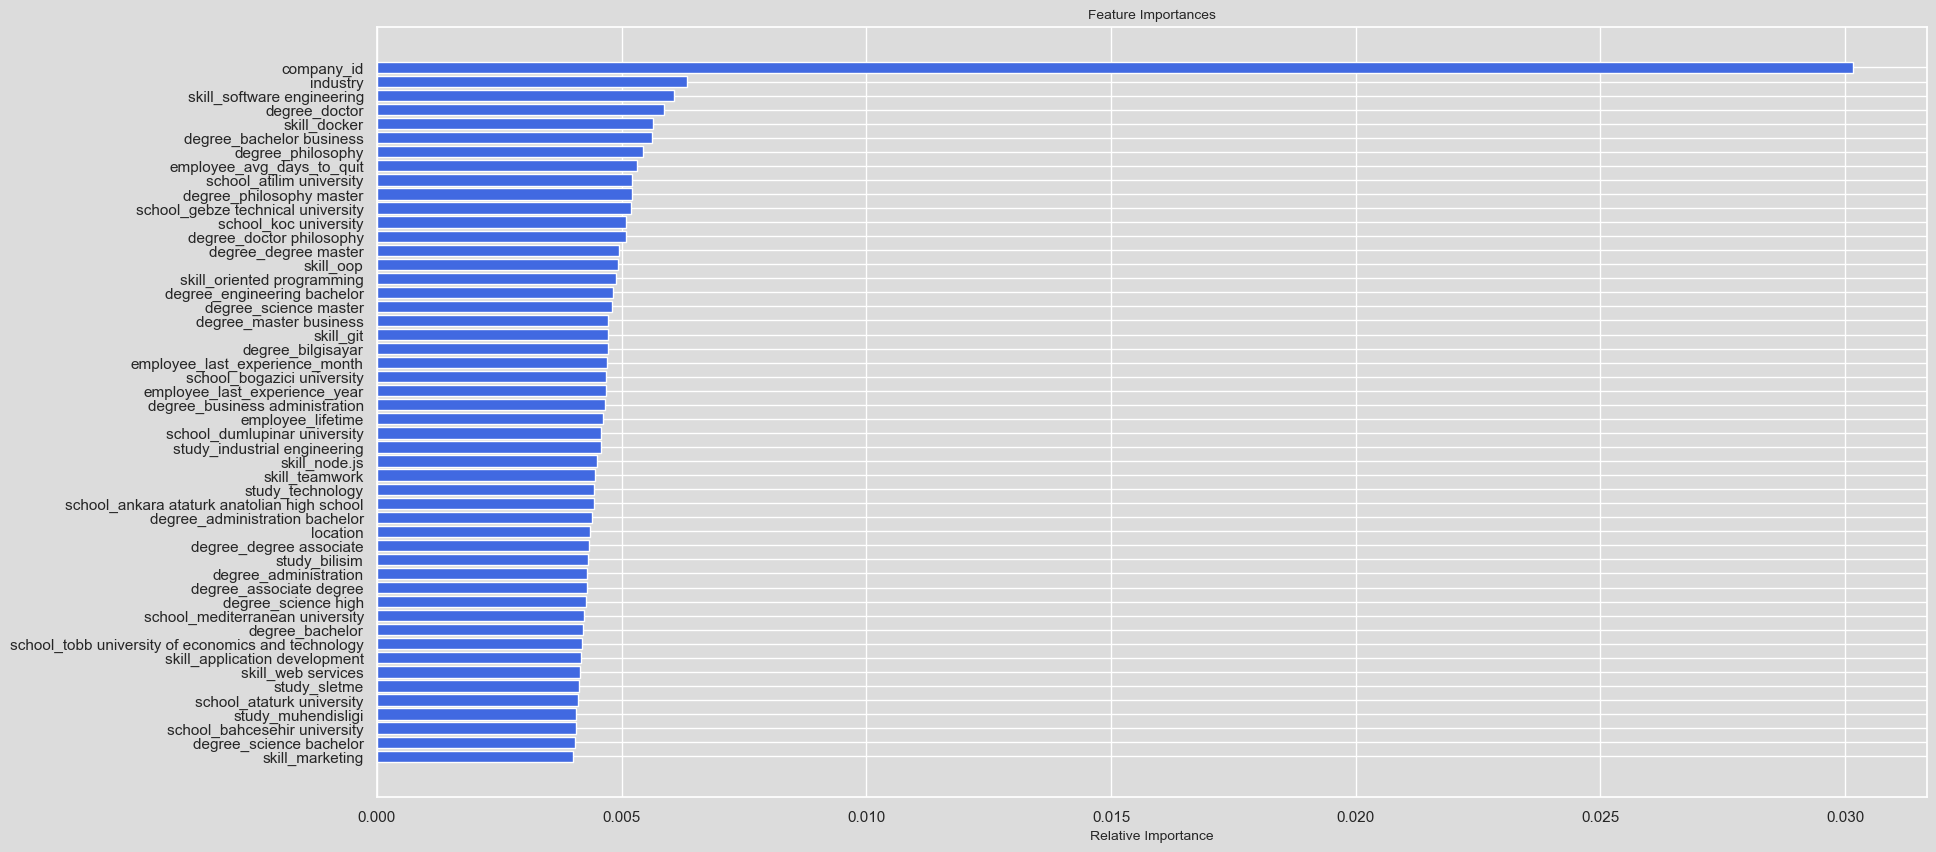

fold accuracy: 0.7887052965142598
accuracy: 0.7862464399554877
folds avg accuracy: 0.7862464467417275


In [14]:
xgb2_scores, xgb2_train_scores = get_model_scores(xgb2, kf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #0.7870197476376394

In [26]:
score_ = list()
for i in np.arange(0.02, 0.98, 0.02):
    score_.append(accuracy_score(train_set[target],
     np.where((cat1_train_scores[:, 1] * 0.62) + (xgb1_train_scores[:, 1] * 0.22) + (xgb2_train_scores[:, 1] * 0.16)  >= 0.499, 1, 0)
                                )
                )

print(f'max score: {np.max(score_)}')
print(np.arange(0.02, 0.98, 0.02)[np.argmax(score_)])

max score: 0.7906976744186046
0.02


In [25]:
sub[target] = np.where((cat1_scores[:, 1] * 0.62) + (xgb1_scores[:, 1] * 0.22) + (xgb2_scores[:, 1] * 0.16)  >= 0.499, 1, 0)

print(sub[target].value_counts())

sub.head(10)

0    9119
1    4136
Name: moved_after_2019, dtype: int64


,user_id,moved_after_2019
0,17449,0
1,33967,0
2,2110,0
3,55082,0
4,37165,0
5,42841,1
6,8407,0
7,17053,0
8,24437,1
9,44394,0


In [28]:
sub.to_csv(f'../submissions/old_version_ensemble_{round(np.max(score_), 6)}.csv', index = False)